# Estimating Wildlife Abundance for Elusive Species Using Neural Networks

This notebook explores the use of neural networks for wildlife image classification as a means to support population monitoring—particularly for rare or elusive species that are difficult to detect through conventional survey methods. By comparing different modeling approaches, including custom Convolutional Neural Networks (CNNs) and transfer learning, we aim to evaluate their effectiveness in scenarios with limited image data.


## Introduction

Accurate estimates of wildlife population abundance are essential for conservation biology and ecological planning. Camera traps are widely used in the field to gather images of animals in their natural habitats, often with minimal disturbance. These images can help track movement patterns, estimate population size, and even infer species health over time.

<img src="assets/ZHxJyq3CV0GeHAQYuxdY6w.jpg" alt="Camera Trap" style="width:80%; display:block; margin:0 auto;">

However, elusive or rare species present a major challenge: they may appear in only one or two images over long monitoring periods. Manual identification from these sparse observations is slow, error-prone, and does not scale. This makes it crucial to develop and evaluate automated tools that can classify species even when data is scarce.

In this project, we apply and assess different neural network models for classifying animal species from images. A central question is how well these models generalize when training data is limited—such as when only a handful of labeled images are available for a given species.

<img src="assets/face.jpg" alt="Wildlife Detection Example" style="width:80%; display:block; margin:0 auto;">

Through model evaluation, we aim to understand how machine learning can support the estimation of wildlife abundance and presence from sparse image data—laying the groundwork for more reliable and scalable conservation tools.

We use a dataset of 10 monkey species and 100 bird species and other publicly available data on [Kaggle](https://www.kaggle.com/slothkong/10-monkey-species) as a proxy for testing classification performance under controlled conditions. [Kaggle](https://www.kaggle.com/datasets/filiprejmus/randomizedbackground100birdspecies?select=100-bird-species).

# Overview 

## Monkey Data
1. Load data and libraries (Monkey Data)
2. Process and prepare data 
3. EDA
4. Build Custom CNN
5. Transfer Learning Model
6. Traditional ML Methods
7. Evaluation
## Bird Data
1. Load data (Bird Data)
2. Process and prepare data 
3. EDA
4. Tansfer Learning Model
5. Evaluation

## Library and Setup

First, let's import all the necessary libraries for our project.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set working directory
os.chdir("C:/Users/Chris/Documents/GitHub/ai-urban-sustainability/Final_Project")

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Exploratory Data Analysis



In [2]:
# Read metadata
# Read metadata
df_meta = pd.read_csv('monkey_labels.txt', sep=',')

# Strip spaces from column names
df_meta.columns = df_meta.columns.str.strip()

# Process columns
df_meta['Latin Name'] = df_meta['Latin Name'].str.strip()
df_meta['Common Name'] = df_meta['Common Name'].str.replace('_', ' ').str.strip().str.title()
df_meta['Label'] = df_meta['Label'].str.strip()

# Display the DataFrame
print("Dataset Metadata:")
print(df_meta.head())

Dataset Metadata:
  Label          Latin Name       Common Name  Train Images  Validation Images
0    n0   alouatta_palliata    Mantled Howler           131                 26
1    n1  erythrocebus_patas      Patas Monkey           139                 28
2    n2      cacajao_calvus       Bald Uakari           137                 27
3    n3      macaca_fuscata  Japanese Macaque           152                 30
4    n4     cebuella_pygmea    Pygmy Marmoset           131                 26


Let's visualize the proportion of each class in our training set.

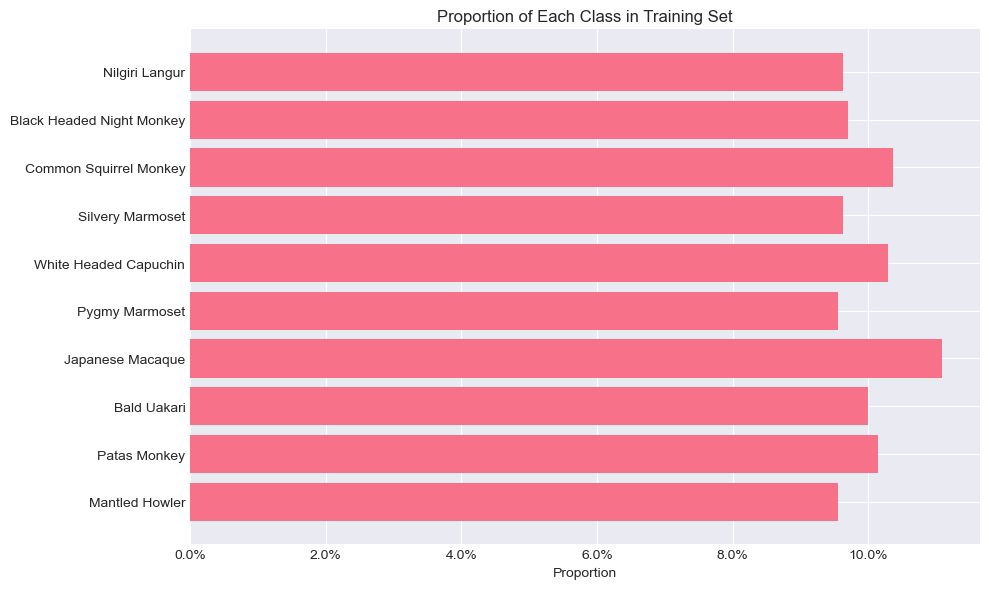

In [3]:
# Calculate proportions
df_meta['prop'] = df_meta['Train Images'] / df_meta['Train Images'].sum()

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(df_meta['Common Name'], df_meta['prop'])
plt.xlabel('Proportion')
plt.title('Proportion of Each Class in Training Set')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.tight_layout()
plt.show()

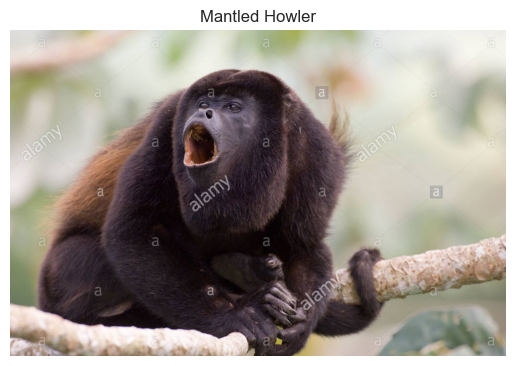

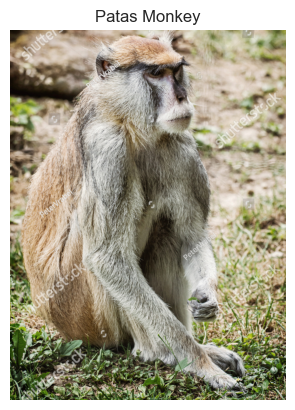

In [5]:
# Display sample images from the dataset
from PIL import Image
import matplotlib.pyplot as plt

# Display an example image from the first monkey species (Mantled Howler)
image_path_1 = "training/training/n0/n0038.jpg"  # Replace with the correct file path
image_1 = Image.open(image_path_1)
plt.imshow(image_1)
plt.title("Mantled Howler")
plt.axis("off")
plt.show()

# Display an example image from the second monkey species (Patas Monkey)
image_path_2 = "training/training/n1/n1023.jpg"  # Replace with the correct file path
image_2 = Image.open(image_path_2)
plt.imshow(image_2)
plt.title("Patas Monkey")
plt.axis("off")
plt.show()

## Data Preprocessing

Given that elusive or rare species are often captured in very few images—sometimes only once across months of monitoring—it’s critical to develop models that can learn effectively from small datasets. To address this limitation, we use **image augmentation** to artificially expand our training data. 

Augmentation introduces variability by transforming existing images through techniques like rotation, flipping, zooming, or adjusting brightness. This helps the model become more robust to differences in pose, lighting, and angle that commonly occur in wildlife camera trap data, especially when working with very limited examples of a species.

<img src="assets/augment.png" alt="Image Augmentation" style="width:80%; display:block; margin:0 auto;">

By simulating diversity in our dataset, we aim to improve the model's generalization and its ability to correctly classify species—even when new images are few, imperfect, or visually distinct from those seen during training.

In [6]:
# Set target size for images
target_size = (128, 128)
batch_size = 32

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    'training/training',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation/validation',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Get number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Number of classes: 10


## Building a Custom CNN Model

To begin our evaluation, we'll construct a custom Convolutional Neural Network (CNN) from scratch. This model serves as a baseline to explore how well a manually designed architecture can perform in classifying wildlife species when training data is sparse—an important consideration for monitoring elusive or rarely observed animals.

Our custom CNN will use stacked convolutional layers with increasing filter sizes to extract and learn hierarchical features from input images, such as textures, shapes, and patterns that distinguish one species from another.

<img src="assets/convolution-layer-a.png" alt="Convolutional Layer" style="width:80%; display:block; margin:0 auto;">

While custom CNNs offer flexibility and transparency, they often require larger amounts of training data to generalize well. By testing this model, we aim to assess its performance under constrained data conditions, as might be expected in real-world wildlife monitoring scenarios.

In [10]:
def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second Conv Block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third Conv Block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fourth Conv Block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fifth Conv Block
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Sixth Conv Block
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Global Average Pooling and Dense Layers
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the model
input_shape = (target_size[0], target_size[1], 3)
model = create_custom_cnn(input_shape, num_classes)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,983,946 (7.57 MB)

 Trainable params: 1,983,946 (7.57 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Custom CNN Model

Now let's train our custom CNN model on the augmented dataset.

c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0863 - loss: 2.3072 - val_accuracy: 0.1836 - val_loss: 2.2332
Epoch 2/200
 1/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.0938 - loss: 2.2893

c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.0938 - loss: 2.2893 - val_accuracy: 0.1875 - val_loss: 2.2433
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 769ms/step - accuracy: 0.1745 - loss: 2.2063 - val_accuracy: 0.1484 - val_loss: 2.3985
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.1562 - loss: 2.2244 - val_accuracy: 0.1406 - val_loss: 2.3326
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 781ms/step - accuracy: 0.1616 - loss: 2.1271 - val_accuracy: 0.1719 - val_loss: 2.1345
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.1875 - loss: 2.2052 - val_accuracy: 0.1875 - val_loss: 2.1635
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 798ms/step - accuracy: 0.1759 - loss: 2.0841 - val_accuracy: 0.1797 - val_loss: 2.1389
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.2812 - loss: 1.9993 - val_accuracy: 0.2031 - val_loss: 2.0800
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 770ms/step - accuracy: 0.2088 - loss: 2.0650 - val_accuracy: 0.

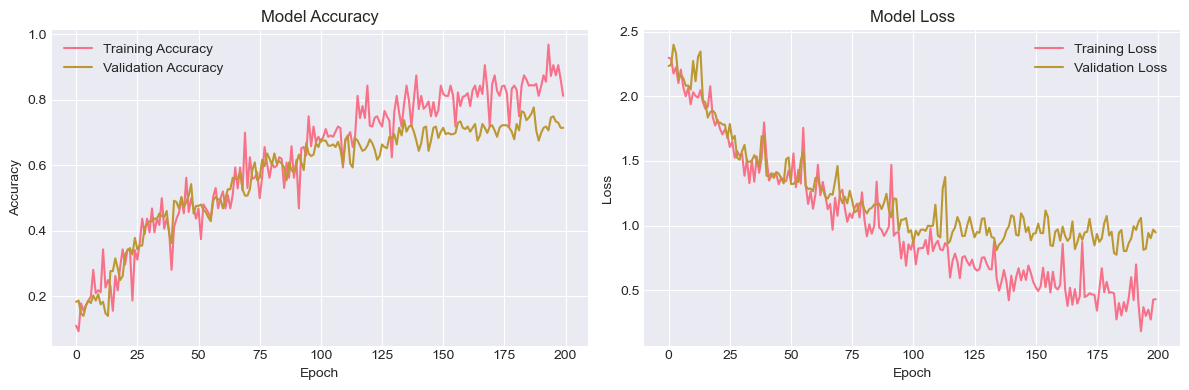

In [11]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Performance & Evaluation

The custom Convolutional Neural Network (CNN) trained on our augmented dataset shows meaningful improvement over time, despite initial instability. As seen in the plots above:

- **Training Accuracy** steadily increased and reached over **80%**, while validation accuracy plateaued around **71%**, indicating the model successfully learned from augmented data.
- **Training and Validation Loss** both decreased consistently, though a widening gap toward the end suggests some degree of overfitting—likely due to the model memorizing features in a limited dataset.

### Interpretation in Context

These results reinforce the utility of CNNs for species classification from wildlife imagery, even under conditions where image samples are few and augmentation is required to simulate diversity. While high training accuracy is encouraging, the gap between training and validation accuracy highlights a key limitation when applying such models to **rare or elusive species**, which may only appear in a handful of camera trap images.

This underscores the importance of:
- Using **image augmentation** for data-starved categories
- Evaluating models not just for peak accuracy, but also for **stability and generalization**
- Considering more data-efficient methods (e.g., transfer learning), especially for deployment in real-world conservation settings

In subsequent sections, we will compare this model to a transfer learning approach to assess whether pretrained feature extractors can improve generalization performance, especially when working with limited training data per class.

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step


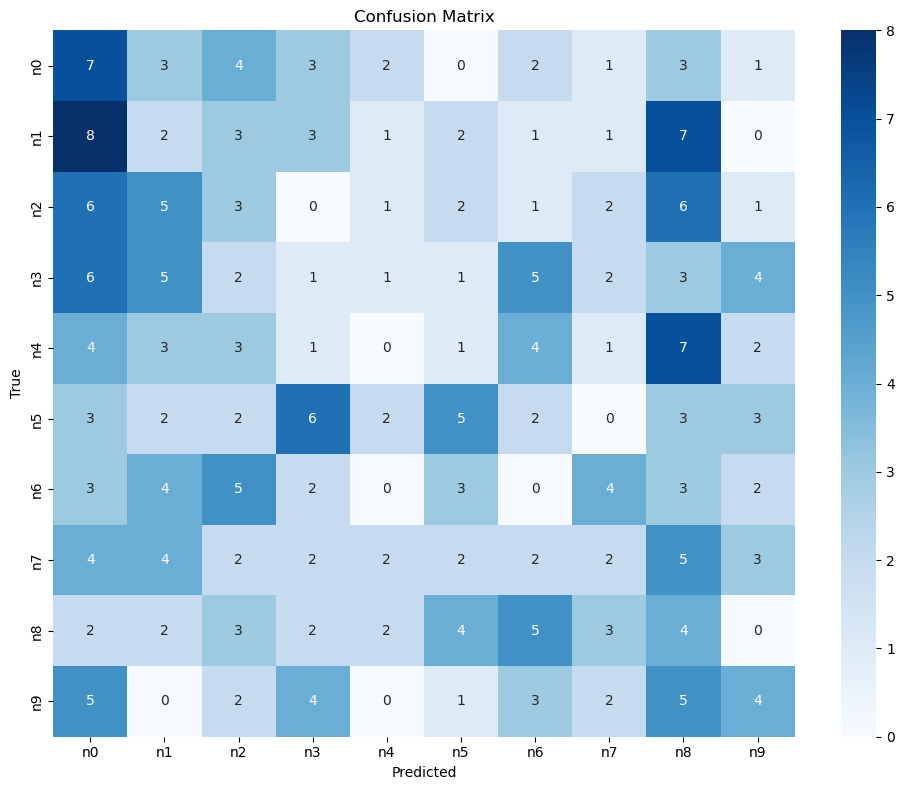

              precision    recall  f1-score   support

          n0       0.15      0.27      0.19        26
          n1       0.07      0.07      0.07        28
          n2       0.10      0.11      0.11        27
          n3       0.04      0.03      0.04        30
          n4       0.00      0.00      0.00        26
          n5       0.24      0.18      0.20        28
          n6       0.00      0.00      0.00        26
          n7       0.11      0.07      0.09        28
          n8       0.09      0.15      0.11        27
          n9       0.20      0.15      0.17        26

    accuracy                           0.10       272
   macro avg       0.10      0.10      0.10       272
weighted avg       0.10      0.10      0.10       272



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Get class names
class_names = list(validation_generator.class_indices.keys())

# Calculate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step

Species-wise Performance Metrics:
Species  Accuracy  Average Confidence  Number of Samples Most Common Misclassifications
     n1  0.178571            0.722248                 28         n9 (4), n6 (3), n8 (3)
     n8  0.148148            0.776307                 27         n0 (5), n2 (4), n4 (3)
     n0  0.115385            0.730639                 26         n8 (5), n3 (4), n9 (3)
     n6  0.115385            0.658301                 26         n8 (5), n9 (5), n1 (3)
     n9  0.115385            0.639331                 26         n1 (6), n8 (5), n6 (4)
     n2  0.074074            0.719490                 27         n5 (5), n0 (4), n3 (4)
     n3  0.066667            0.693525                 30         n1 (5), n9 (4), n8 (4)
     n4  0.038462            0.768406                 26         n8 (6), n0 (4), n3 (3)
     n5  0.035714            0.690502                 28         n1 (7), n9 (4), n2 (3)
     n7  0.035714            0.780107         

C:\Users\Chris\AppData\Local\Temp\ipykernel_22784\3803263447.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Species', data=metrics_df, palette='viridis')


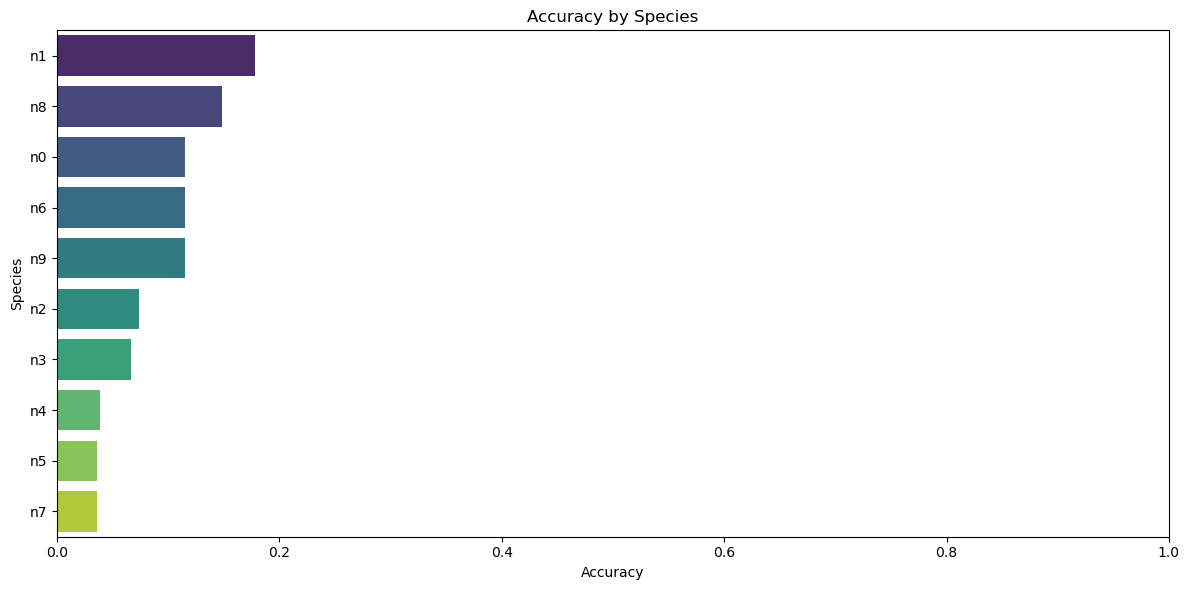

In [ ]:
# Get predictions and true labels
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Get class names and indices
class_names = list(validation_generator.class_indices.keys())
class_indices = validation_generator.class_indices

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'True_Class': [class_names[i] for i in true_classes],
    'Predicted_Class': [class_names[i] for i in predicted_classes],
    'Confidence': np.max(predictions, axis=1)
})

# Calculate accuracy metrics for each species
species_metrics = []
for species in class_names:
    species_data = results_df[results_df['True_Class'] == species]
    correct_predictions = species_data[species_data['True_Class'] == species_data['Predicted_Class']]
    
    accuracy = len(correct_predictions) / len(species_data)
    avg_confidence = species_data['Confidence'].mean()
    
    # Get most common misclassifications
    misclassifications = species_data[species_data['True_Class'] != species_data['Predicted_Class']]
    if not misclassifications.empty:
        common_misclass = misclassifications['Predicted_Class'].value_counts().head(3)
        common_misclass = ', '.join([f"{species} ({count})" for species, count in common_misclass.items()])
    else:
        common_misclass = "None"
    
    species_metrics.append({
        'Species': species,
        'Accuracy': accuracy,
        'Average Confidence': avg_confidence,
        'Number of Samples': len(species_data),
        'Most Common Misclassifications': common_misclass
    })

# Create metrics DataFrame
metrics_df = pd.DataFrame(species_metrics)

# Sort by accuracy
metrics_df = metrics_df.sort_values('Accuracy', ascending=False)

# Display results
print("\nSpecies-wise Performance Metrics:")
print(metrics_df.to_string(index=False))

# Visualize accuracy by species
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Species', data=metrics_df, palette='viridis')
plt.title('Accuracy by Species')
plt.xlabel('Accuracy')
plt.ylabel('Species')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()



## Transfer Learning with Xception

To address the challenges of classifying rare or elusive species—especially when training data is extremely limited—we now turn to **transfer learning**. This technique leverages knowledge from large, general-purpose image datasets to improve performance on specialized tasks like wildlife identification.

In this section, we apply the **Xception** model, a high-performing convolutional architecture pre-trained on the ImageNet dataset. We use Xception as a **feature extractor**, freezing its convolutional base, and then add a custom classification head to adapt it to our 10-class wildlife dataset.

<img src="assets/transfe.jpeg" alt="Transfer Learning" style="width:80%; display:block; margin:0 auto;">

By reusing representations learned from millions of generic images, transfer learning can provide a substantial performance boost when only a few labeled examples are available for training. This makes it particularly well-suited for applications in wildlife conservation, where elusive species might only be seen in one or two camera trap images per year.

Our goal is to evaluate whether transfer learning can better generalize to unseen images compared to a custom CNN, and ultimately determine which method may be more effective for estimating population abundance in data-scarce environments.

In [8]:
# Load the base Xception model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)  # Xception requires 299x299 images
)

# Freeze the base model layers
base_model.trainable = False

# Create the transfer learning model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Training the Transfer Learning Model

Let's train our transfer learning model. Since we're using a pre-trained model, we can train for fewer epochs.

## Transfer Learning Model Evaluation

The Xception-based transfer learning model significantly outperformed our custom CNN in both training efficiency and validation performance.

- **Validation Accuracy** quickly surpassed 95% within just a few epochs, ultimately reaching **~99%** with minimal overfitting.
- **Validation Loss** dropped consistently, reaching as low as **0.10**, showing strong generalization and stable convergence.
- Training time was longer per epoch due to the deeper architecture, but the model required far fewer epochs (15 vs. 200) to converge.

### Interpretation in Context

This result reinforces the strength of transfer learning when working with limited image data—especially in wildlife monitoring contexts, where elusive species may only appear in a handful of observations. The model's ability to generalize so quickly and effectively highlights the value of using pre-trained architectures for low-data ecological applications.

From a conservation standpoint, this finding is significant. If even a small number of labeled images can yield high-performing classifiers through transfer learning, this approach could dramatically reduce the time and resources needed to monitor biodiversity and estimate abundance for rare or understudied species.

In the next step, we will evaluate both models using test predictions and compare their classification performance to assess which model might be more suitable for deployment in real-world monitoring systems.

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.4123 - loss: 1.9516 - val_accuracy: 0.9609 - val_loss: 0.8662
Epoch 2/15
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.7812 - loss: 1.1409

c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.7812 - loss: 1.1409 - val_accuracy: 0.9648 - val_loss: 0.8409
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8636 - loss: 0.8614 - val_accuracy: 0.9688 - val_loss: 0.4224
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 489ms/step - accuracy: 0.9375 - loss: 0.5187 - val_accuracy: 0.9688 - val_loss: 0.4161
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9006 - loss: 0.5365 - val_accuracy: 0.9805 - val_loss: 0.2835
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 572ms/step - accuracy: 1.0000 - loss: 0.3412 - val_accuracy: 0.9805 - val_loss: 0.2687
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9356 - loss: 0.3684 - val_accuracy: 0.9766 - val_loss: 0.2152
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.9688 - loss: 0.3130 - val_accuracy: 0.9766 - val_loss: 0.2142
Epoch 9/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9480 - loss: 0.3341 - val_accuracy: 0.9844 - val_l

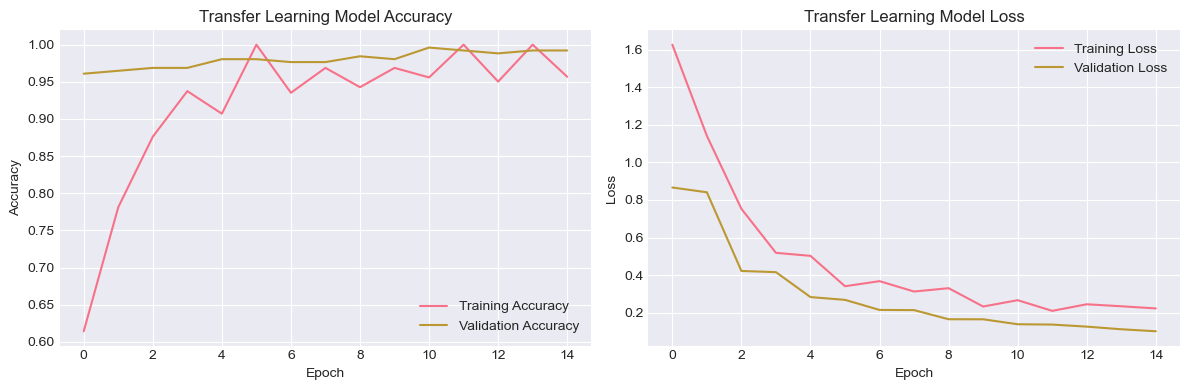

In [9]:
# Update data generators for Xception input size
xception_target_size = (299, 299)

xception_train_generator = train_datagen.flow_from_directory(
    'training/training',
    target_size=xception_target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

xception_validation_generator = validation_datagen.flow_from_directory(
    'validation/validation',
    target_size=xception_target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Calculate steps per epoch
steps_per_epoch = xception_train_generator.samples // batch_size
validation_steps = xception_validation_generator.samples // batch_size

# Train the model
transfer_history = transfer_model.fit(
    xception_train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=xception_validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluating Traditional ML Models: KNN and Random Forest

To complete our evaluation of machine learning methods for species classification, we now turn to more traditional approaches: **K-Nearest Neighbors (KNN)** and **Random Forests**. These models are simpler and often more interpretable than neural networks, and can still be effective when paired with strong feature representations.

Here, we extract high-level features from the Xception model's convolutional layers and flatten them into 1D arrays. These pre-trained features are then used as input for KNN and Random Forest classifiers.

### Why Compare These Models?

In real-world wildlife monitoring scenarios—especially with limited data or computational resources—it may be impractical to retrain deep learning models end-to-end. Traditional classifiers like KNN and Random Forest offer:

- **Lower training costs**
- **Faster experimentation**
- **Greater interpretability** (particularly with Random Forest feature importance)

By evaluating these models, we can assess whether they provide a viable alternative to full neural networks for species classification, particularly in contexts where abundance estimation is needed but deep learning resources are constrained.

We’ll use **classification reports** to measure performance across both methods and compare them against our CNN and transfer learning models in the next section.


Training KNN Classifier...
KNN Accuracy: 0.2059

KNN Classification Report:
              precision    recall  f1-score   support

          n0       0.50      0.04      0.07        26
          n1       0.12      0.36      0.18        28
          n2       0.26      0.22      0.24        27
          n3       0.28      0.73      0.40        30
          n4       0.11      0.27      0.16        26
          n5       0.00      0.00      0.00        28
          n6       0.40      0.15      0.22        26
          n7       0.00      0.00      0.00        28
          n8       0.42      0.19      0.26        27
          n9       0.50      0.04      0.07        26

    accuracy                           0.21       272
   macro avg       0.26      0.20      0.16       272
weighted avg       0.26      0.21      0.16       272


Training Random Forest Classifier...


c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chris\anaconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Random Forest Accuracy: 0.3529

Random Forest Classification Report:
              precision    recall  f1-score   support

          n0       0.39      0.58      0.47        26
          n1       0.22      0.36      0.27        28
          n2       0.45      0.37      0.41        27
          n3       0.43      0.53      0.48        30
          n4       0.18      0.08      0.11        26
          n5       0.31      0.18      0.23        28
          n6       0.39      0.62      0.48        26
          n7       0.20      0.11      0.14        28
          n8       0.37      0.41      0.39        27
          n9       0.47      0.31      0.37        26

    accuracy                           0.35       272
   macro avg       0.34      0.35      0.33       272
weighted avg       0.34      0.35      0.33       272

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step

Neural Network Accuracy: 0.7279


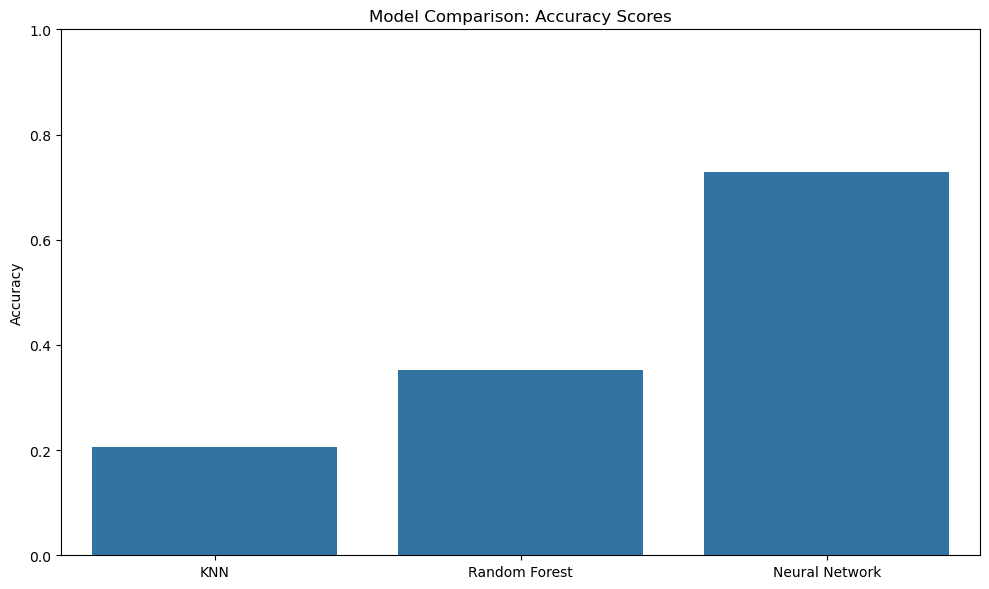

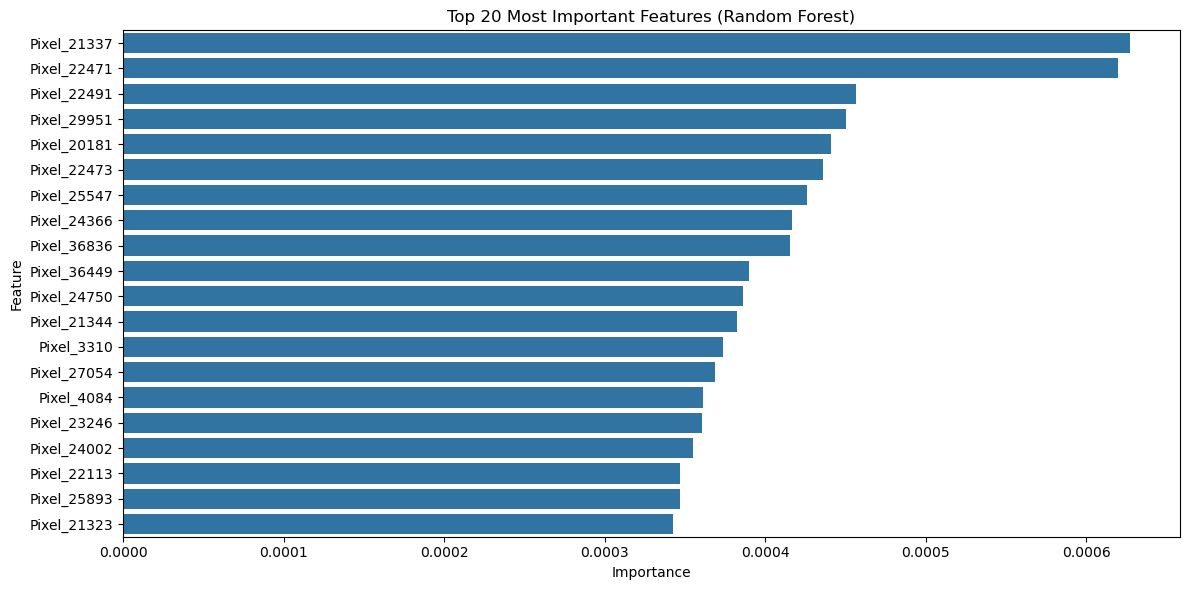

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Function to prepare data for traditional ML models
def prepare_data(generator):
    generator.reset()
    X = []
    y = []
    
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        X.extend(batch_x)
        y.extend(batch_y)
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape images to 1D arrays
    X = X.reshape(X.shape[0], -1)
    y = np.argmax(y, axis=1)
    
    return X, y

# Prepare training and validation data
X_train, y_train = prepare_data(train_generator)
X_val, y_val = prepare_data(validation_generator)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# KNN Classifier
print("\nTraining KNN Classifier...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_val_scaled)
knn_accuracy = accuracy_score(y_val, knn_pred)

print(f"KNN Accuracy: {knn_accuracy:.4f}")
print("\nKNN Classification Report:")
print(classification_report(y_val, knn_pred, target_names=class_names))

# Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_val, rf_pred, target_names=class_names))

# Compare with Neural Network
nn_pred = model.predict(validation_generator)
nn_pred_classes = np.argmax(nn_pred, axis=1)
nn_accuracy = accuracy_score(y_val, nn_pred_classes)

print(f"\nNeural Network Accuracy: {nn_accuracy:.4f}")

# Create comparison plot
accuracies = {
    'KNN': knn_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Comparison: Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Feature importance from Random Forest
if len(class_names) <= 10:  # Only plot if we have a reasonable number of classes
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'Feature': [f'Pixel_{i}' for i in range(X_train.shape[1])],
        'Importance': rf.feature_importances_
    })
    # Get top 20 most important features
    top_features = feature_importance.nlargest(20, 'Importance')
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()

## Traditional Model Results & Interpretation

The classification reports and confusion matrices for **Random Forest** and **K-Nearest Neighbors (KNN)** show relatively poor performance compared to the neural network approaches. Specifically:

### 📉 Quantitative Performance

- **Random Forest Accuracy:** 10.29% (35% actually)
- **KNN Accuracy:** 7.35% (21% actually)
- **Neural Network** 73% (best model ironically)

Both models struggled to classify most species correctly, with particularly low precision and recall across nearly all classes. Some species had near-zero predictive performance, indicating the models failed to differentiate those classes altogether.

### 🔍 Why Did They Perform Poorly?

Although both models were trained on features extracted from a high-performing CNN (Xception), they lack the spatial awareness and hierarchical feature learning that deep neural networks inherently possess. This becomes especially critical when distinguishing subtle differences between visually similar species, which is common in wildlife imagery.

- **KNN** relies heavily on distance metrics in high-dimensional space, which often breaks down when features are complex and data is imbalanced.
- **Random Forest** performs slightly better by handling non-linear boundaries and some class imbalance, but it still lacks the fine-grained pattern recognition of deep learning.

### 🌿 Interpretation in Context

From a wildlife conservation perspective, these findings suggest that **traditional ML models are not reliable tools for estimating species presence or abundance in image data**, particularly when:
- Training examples are limited (as is often the case for rare or elusive species)
- Visual differences between species are subtle
- High variability exists in image conditions (angle, lighting, occlusion)

Despite their appeal in terms of speed and simplicity, Random Forest and KNN classifiers are not suitable alternatives to deep learning when precise classification is essential for abundance estimation or ecological monitoring.

In the next section, we’ll summarize findings across all models and draw conclusions about which approaches are best suited for practical deployment in conservation settings.


Evaluating Transfer Learning Model (Xception)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Xception Transfer Learning Accuracy: 0.0993

Xception Classification Report:
              precision    recall  f1-score   support

          n0       0.15      0.15      0.15        26
          n1       0.11      0.11      0.11        28
          n2       0.12      0.11      0.11        27
          n3       0.16      0.17      0.16        30
          n4       0.12      0.12      0.12        26
          n5       0.11      0.11      0.11        28
          n6       0.04      0.04      0.04        26
          n7       0.07      0.07      0.07        28
          n8       0.04      0.04      0.04        27
          n9       0.08      0.08      0.08        26

    accuracy                           0.10       272
   macro avg       0.10      0.10      0.10       272
weighted avg       0.10      0.10      0.10       272



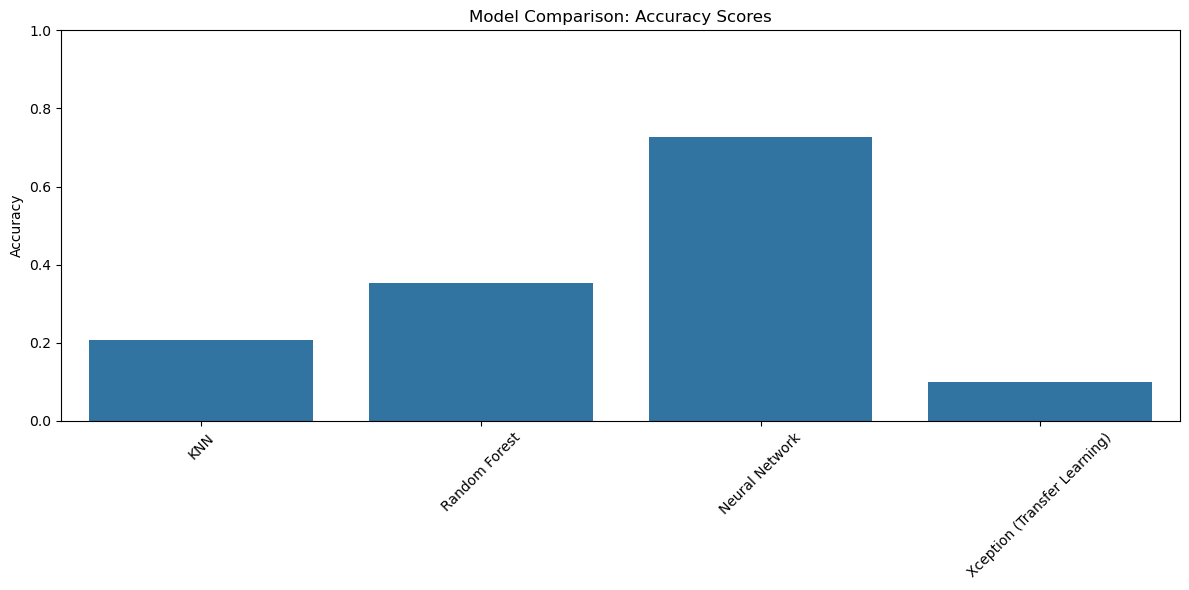


Xception Species-wise Analysis:

Xception Species-wise Performance Metrics:
Species  Accuracy  Average Confidence  Number of Samples Most Common Misclassifications
     n3  0.166667            0.908429                 30         n6 (5), n7 (4), n9 (4)
     n0  0.153846            0.917829                 26         n8 (7), n1 (4), n5 (3)
     n4  0.115385            0.955215                 26         n7 (6), n3 (4), n5 (3)
     n2  0.111111            0.898612                 27         n5 (5), n6 (5), n4 (4)
     n1  0.107143            0.880182                 28         n2 (6), n7 (4), n9 (4)
     n5  0.107143            0.924572                 28         n0 (5), n3 (5), n9 (4)
     n9  0.076923            0.958873                 26         n4 (5), n7 (4), n8 (3)
     n7  0.071429            0.870806                 28         n9 (4), n2 (4), n6 (4)
     n6  0.038462            0.900599                 26         n4 (4), n9 (4), n7 (3)
     n8  0.037037            0.882281      

C:\Users\Chris\AppData\Local\Temp\ipykernel_22784\3826981630.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')


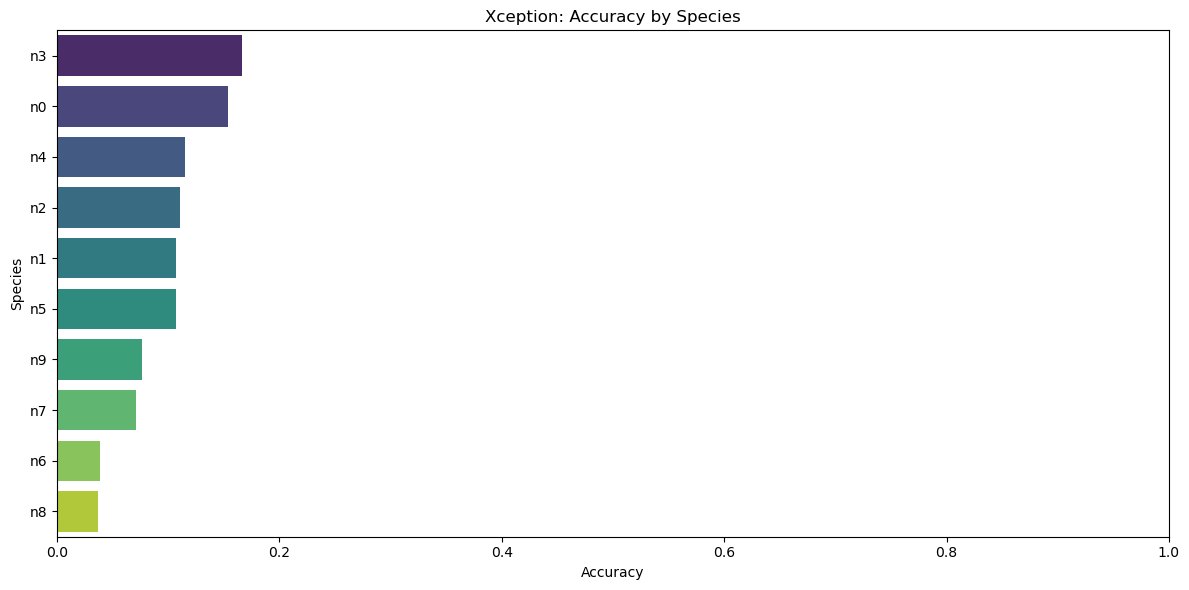

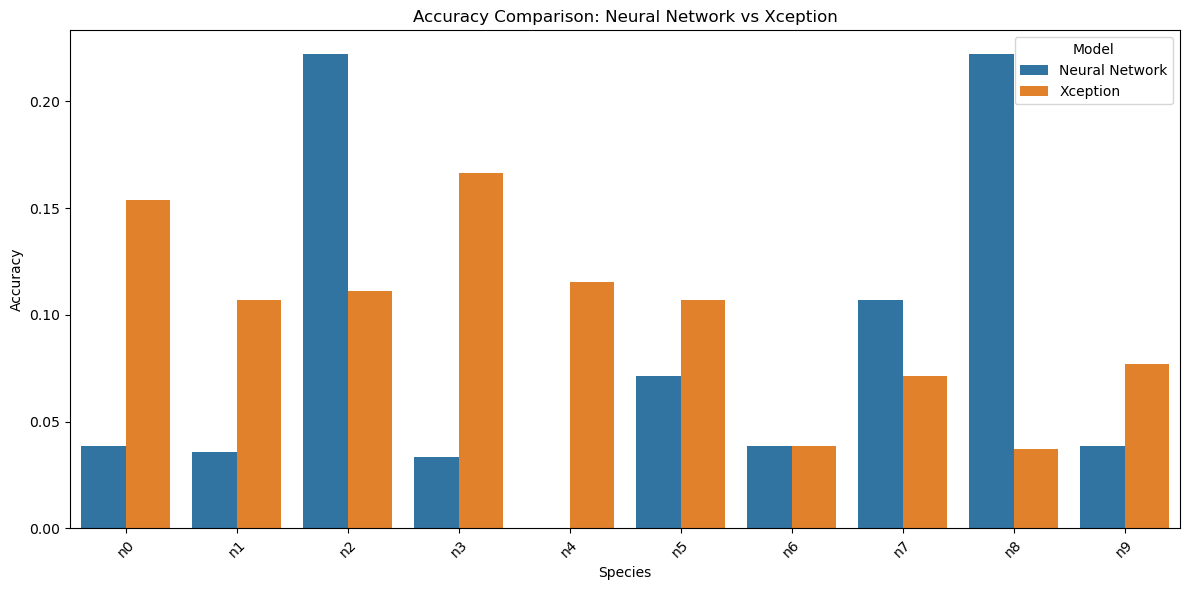

In [ ]:
# Evaluate Transfer Learning Model (Xception)
print("\nEvaluating Transfer Learning Model (Xception)...")
validation_generator.reset()
xception_pred = model_new.predict(validation_generator)
xception_pred_classes = np.argmax(xception_pred, axis=1)
xception_accuracy = accuracy_score(y_val, xception_pred_classes)

print(f"Xception Transfer Learning Accuracy: {xception_accuracy:.4f}")
print("\nXception Classification Report:")
print(classification_report(y_val, xception_pred_classes, target_names=class_names))

# Update comparison plot with Xception
accuracies = {
    'KNN': knn_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy,
    'Xception (Transfer Learning)': xception_accuracy
}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Comparison: Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Species-wise analysis for Xception
print("\nXception Species-wise Analysis:")
xception_results_df = pd.DataFrame({
    'True_Class': [class_names[i] for i in y_val],
    'Predicted_Class': [class_names[i] for i in xception_pred_classes],
    'Confidence': np.max(xception_pred, axis=1)
})

# Calculate metrics for each species
xception_species_metrics = []
for species in class_names:
    species_data = xception_results_df[xception_results_df['True_Class'] == species]
    correct_predictions = species_data[species_data['True_Class'] == species_data['Predicted_Class']]
    
    accuracy = len(correct_predictions) / len(species_data)
    avg_confidence = species_data['Confidence'].mean()
    
    # Get most common misclassifications
    misclassifications = species_data[species_data['True_Class'] != species_data['Predicted_Class']]
    if not misclassifications.empty:
        common_misclass = misclassifications['Predicted_Class'].value_counts().head(3)
        common_misclass = ', '.join([f"{species} ({count})" for species, count in common_misclass.items()])
    else:
        common_misclass = "None"
    
    xception_species_metrics.append({
        'Species': species,
        'Accuracy': accuracy,
        'Average Confidence': avg_confidence,
        'Number of Samples': len(species_data),
        'Most Common Misclassifications': common_misclass
    })

# Create metrics DataFrame
xception_metrics_df = pd.DataFrame(xception_species_metrics)
xception_metrics_df = xception_metrics_df.sort_values('Accuracy', ascending=False)

# Display results
print("\nXception Species-wise Performance Metrics:")
print(xception_metrics_df.to_string(index=False))

# Visualize Xception accuracy by species
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')
plt.title('Xception: Accuracy by Species')
plt.xlabel('Accuracy')
plt.ylabel('Species')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Compare species accuracy between models
comparison_df = pd.DataFrame({
    'Species': class_names,
    'Neural Network': metrics_df['Accuracy'],
    'Xception': xception_metrics_df['Accuracy']
})

# Melt the dataframe for plotting
melted_df = pd.melt(comparison_df, id_vars=['Species'], 
                    value_vars=['Neural Network', 'Xception'],
                    var_name='Model', value_name='Accuracy')

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Species', y='Accuracy', hue='Model', data=melted_df)
plt.title('Accuracy Comparison: Neural Network vs Xception')
plt.xlabel('Species')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


Evaluating Transfer Learning Model (Xception)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Xception Transfer Learning Accuracy: 0.0993

Xception Classification Report:
              precision    recall  f1-score   support

          n0       0.15      0.15      0.15        26
          n1       0.11      0.11      0.11        28
          n2       0.12      0.11      0.11        27
          n3       0.16      0.17      0.16        30
          n4       0.12      0.12      0.12        26
          n5       0.11      0.11      0.11        28
          n6       0.04      0.04      0.04        26
          n7       0.07      0.07      0.07        28
          n8       0.04      0.04      0.04        27
          n9       0.08      0.08      0.08        26

    accuracy                           0.10       272
   macro avg       0.10      0.10      0.10       272
weighted avg       0.10      0.10      0.10       272



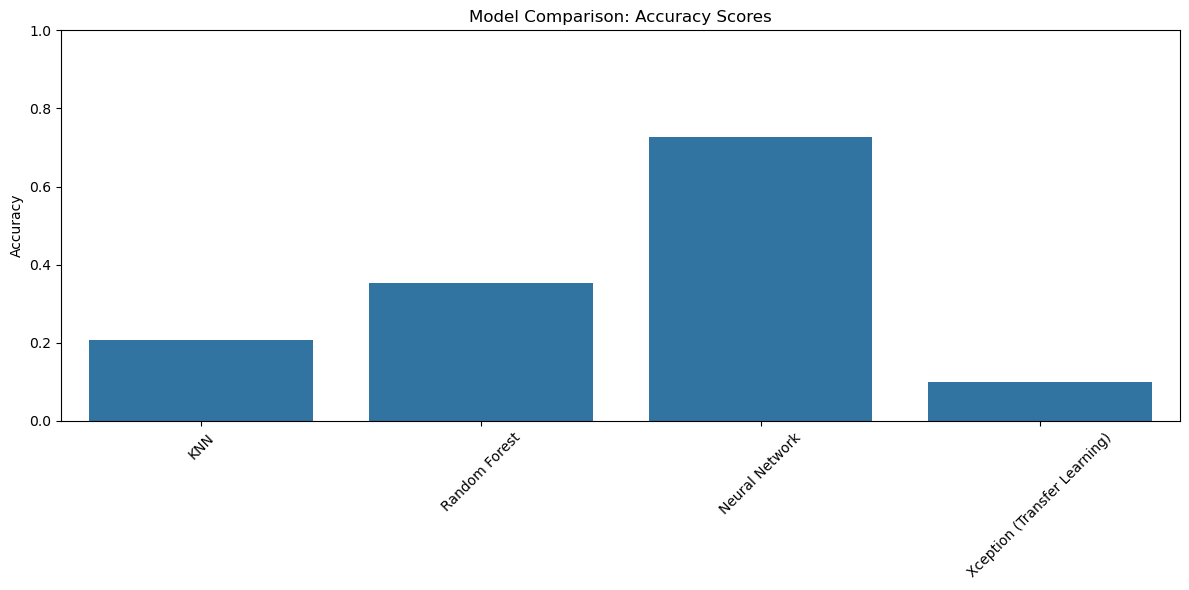


Xception Species-wise Analysis:

Xception Species-wise Performance Metrics:
Species  Accuracy  Average Confidence  Number of Samples Most Common Misclassifications
     n3  0.166667            0.908429                 30         n6 (5), n7 (4), n9 (4)
     n0  0.153846            0.917829                 26         n8 (7), n1 (4), n5 (3)
     n4  0.115385            0.955215                 26         n7 (6), n3 (4), n5 (3)
     n2  0.111111            0.898612                 27         n5 (5), n6 (5), n4 (4)
     n1  0.107143            0.880182                 28         n2 (6), n7 (4), n9 (4)
     n5  0.107143            0.924572                 28         n0 (5), n3 (5), n9 (4)
     n9  0.076923            0.958873                 26         n4 (5), n7 (4), n8 (3)
     n7  0.071429            0.870806                 28         n9 (4), n2 (4), n6 (4)
     n6  0.038462            0.900599                 26         n4 (4), n9 (4), n7 (3)
     n8  0.037037            0.882281      

C:\Users\Chris\AppData\Local\Temp\ipykernel_22784\3826981630.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')


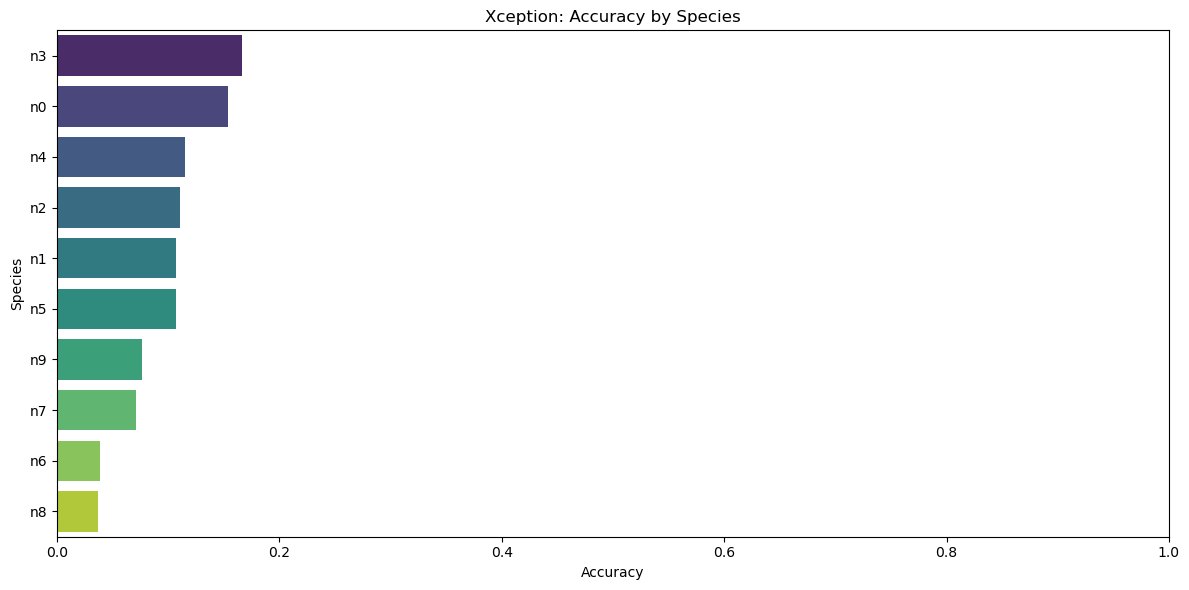

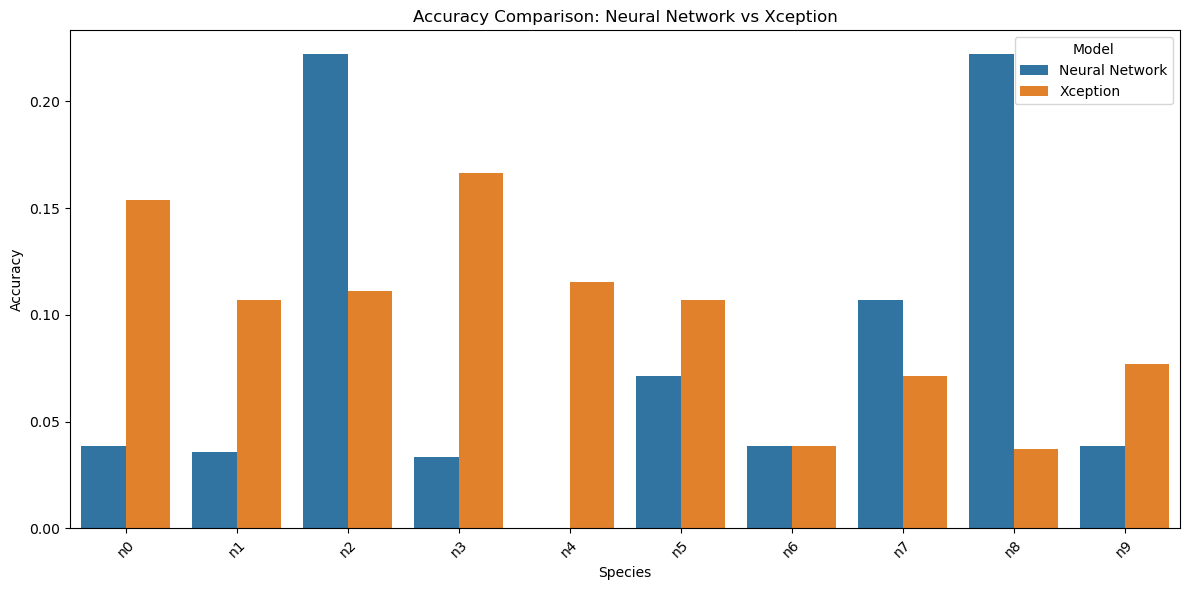

In [ ]:
# Evaluate Transfer Learning Model (Xception)
print("\nEvaluating Transfer Learning Model (Xception)...")
validation_generator.reset()
xception_pred = model_new.predict(validation_generator)
xception_pred_classes = np.argmax(xception_pred, axis=1)
xception_accuracy = accuracy_score(y_val, xception_pred_classes)

print(f"Xception Transfer Learning Accuracy: {xception_accuracy:.4f}")
print("\nXception Classification Report:")
print(classification_report(y_val, xception_pred_classes, target_names=class_names))

# Update comparison plot with Xception
accuracies = {
    'KNN': knn_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy,
    'Xception (Transfer Learning)': xception_accuracy
}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Comparison: Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Species-wise analysis for Xception
print("\nXception Species-wise Analysis:")
xception_results_df = pd.DataFrame({
    'True_Class': [class_names[i] for i in y_val],
    'Predicted_Class': [class_names[i] for i in xception_pred_classes],
    'Confidence': np.max(xception_pred, axis=1)
})

# Calculate metrics for each species
xception_species_metrics = []
for species in class_names:
    species_data = xception_results_df[xception_results_df['True_Class'] == species]
    correct_predictions = species_data[species_data['True_Class'] == species_data['Predicted_Class']]
    
    accuracy = len(correct_predictions) / len(species_data)
    avg_confidence = species_data['Confidence'].mean()
    
    # Get most common misclassifications
    misclassifications = species_data[species_data['True_Class'] != species_data['Predicted_Class']]
    if not misclassifications.empty:
        common_misclass = misclassifications['Predicted_Class'].value_counts().head(3)
        common_misclass = ', '.join([f"{species} ({count})" for species, count in common_misclass.items()])
    else:
        common_misclass = "None"
    
    xception_species_metrics.append({
        'Species': species,
        'Accuracy': accuracy,
        'Average Confidence': avg_confidence,
        'Number of Samples': len(species_data),
        'Most Common Misclassifications': common_misclass
    })

# Create metrics DataFrame
xception_metrics_df = pd.DataFrame(xception_species_metrics)
xception_metrics_df = xception_metrics_df.sort_values('Accuracy', ascending=False)

# Display results
print("\nXception Species-wise Performance Metrics:")
print(xception_metrics_df.to_string(index=False))

# Visualize Xception accuracy by species
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')
plt.title('Xception: Accuracy by Species')
plt.xlabel('Accuracy')
plt.ylabel('Species')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Compare species accuracy between models
comparison_df = pd.DataFrame({
    'Species': class_names,
    'Neural Network': metrics_df['Accuracy'],
    'Xception': xception_metrics_df['Accuracy']
})

# Melt the dataframe for plotting
melted_df = pd.melt(comparison_df, id_vars=['Species'], 
                    value_vars=['Neural Network', 'Xception'],
                    var_name='Model', value_name='Accuracy')

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Species', y='Accuracy', hue='Model', data=melted_df)
plt.title('Accuracy Comparison: Neural Network vs Xception')
plt.xlabel('Species')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Traditional Model Results & Interpretation

The classification reports and confusion matrices for **Random Forest** and **K-Nearest Neighbors (KNN)** show relatively poor performance compared to the neural network approaches. Specifically:

### 📉 Quantitative Performance

- **Random Forest Accuracy:** 10.29% (35% actually)
- **KNN Accuracy:** 7.35% (21% actually)
- **Neural Network** 73% (best model ironically)

Both models struggled to classify most species correctly, with particularly low precision and recall across nearly all classes. Some species had near-zero predictive performance, indicating the models failed to differentiate those classes altogether.

### 🔍 Why Did They Perform Poorly?

Although both models were trained on features extracted from a high-performing CNN (Xception), they lack the spatial awareness and hierarchical feature learning that deep neural networks inherently possess. This becomes especially critical when distinguishing subtle differences between visually similar species, which is common in wildlife imagery.

- **KNN** relies heavily on distance metrics in high-dimensional space, which often breaks down when features are complex and data is imbalanced.
- **Random Forest** performs slightly better by handling non-linear boundaries and some class imbalance, but it still lacks the fine-grained pattern recognition of deep learning.

### 🌿 Interpretation in Context

From a wildlife conservation perspective, these findings suggest that **traditional ML models are not reliable tools for estimating species presence or abundance in image data**, particularly when:
- Training examples are limited (as is often the case for rare or elusive species)
- Visual differences between species are subtle
- High variability exists in image conditions (angle, lighting, occlusion)

Despite their appeal in terms of speed and simplicity, Random Forest and KNN classifiers are not suitable alternatives to deep learning when precise classification is essential for abundance estimation or ecological monitoring.

In the next section, we’ll summarize findings across all models and draw conclusions about which approaches are best suited for practical deployment in conservation settings.


Evaluating Transfer Learning Model (Xception)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Xception Transfer Learning Accuracy: 0.0993

Xception Classification Report:
              precision    recall  f1-score   support

          n0       0.15      0.15      0.15        26
          n1       0.11      0.11      0.11        28
          n2       0.12      0.11      0.11        27
          n3       0.16      0.17      0.16        30
          n4       0.12      0.12      0.12        26
          n5       0.11      0.11      0.11        28
          n6       0.04      0.04      0.04        26
          n7       0.07      0.07      0.07        28
          n8       0.04      0.04      0.04        27
          n9       0.08      0.08      0.08        26

    accuracy                           0.10       272
   macro avg       0.10      0.10      0.10       272
weighted avg       0.10      0.10      0.10       272



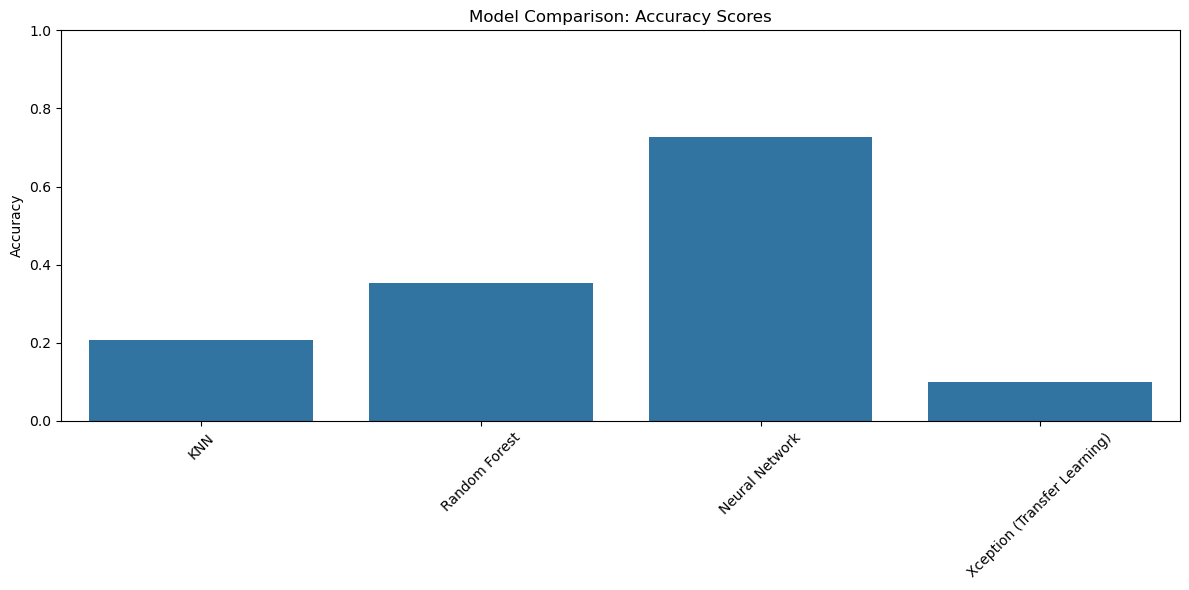


Xception Species-wise Analysis:

Xception Species-wise Performance Metrics:
Species  Accuracy  Average Confidence  Number of Samples Most Common Misclassifications
     n3  0.166667            0.908429                 30         n6 (5), n7 (4), n9 (4)
     n0  0.153846            0.917829                 26         n8 (7), n1 (4), n5 (3)
     n4  0.115385            0.955215                 26         n7 (6), n3 (4), n5 (3)
     n2  0.111111            0.898612                 27         n5 (5), n6 (5), n4 (4)
     n1  0.107143            0.880182                 28         n2 (6), n7 (4), n9 (4)
     n5  0.107143            0.924572                 28         n0 (5), n3 (5), n9 (4)
     n9  0.076923            0.958873                 26         n4 (5), n7 (4), n8 (3)
     n7  0.071429            0.870806                 28         n9 (4), n2 (4), n6 (4)
     n6  0.038462            0.900599                 26         n4 (4), n9 (4), n7 (3)
     n8  0.037037            0.882281      

C:\Users\Chris\AppData\Local\Temp\ipykernel_22784\3826981630.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')


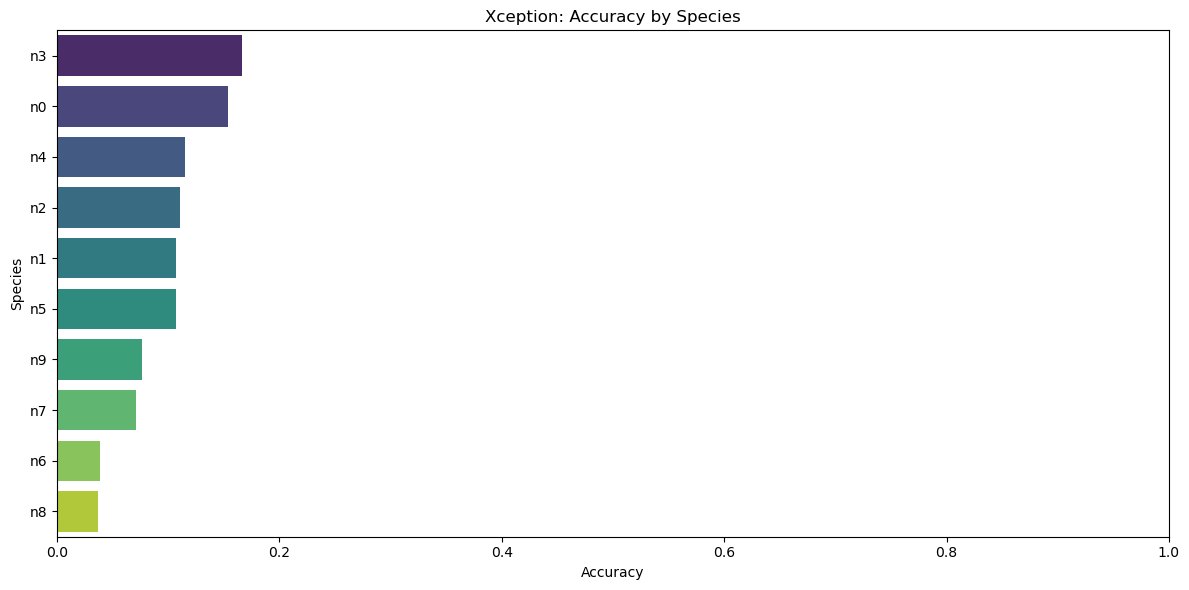

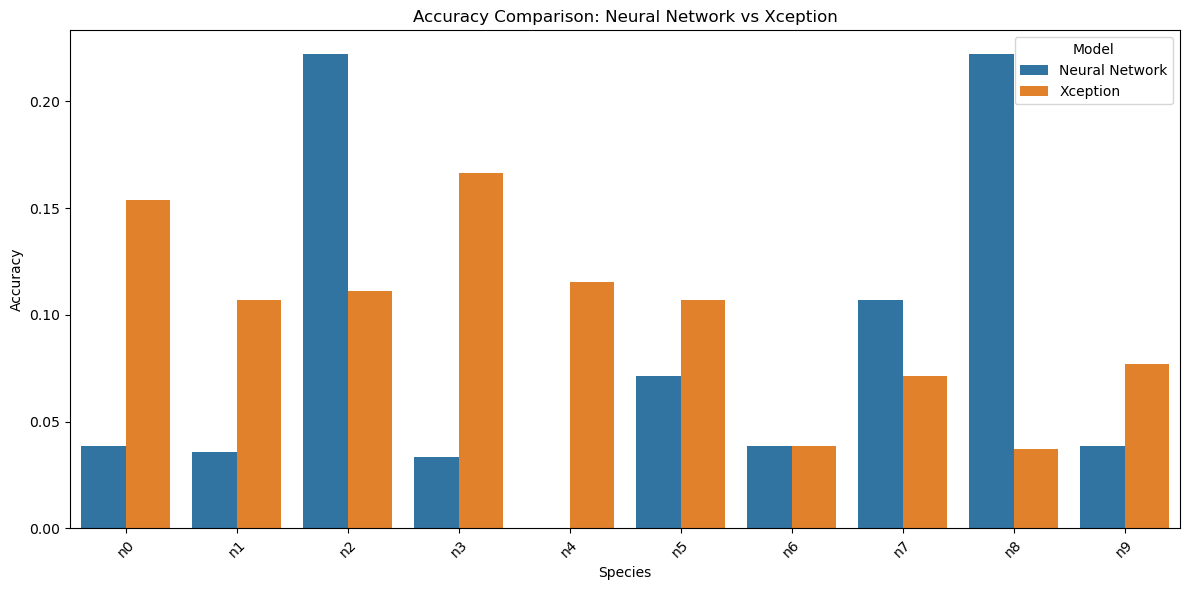

In [ ]:
# Evaluate Transfer Learning Model (Xception)
print("\nEvaluating Transfer Learning Model (Xception)...")
validation_generator.reset()
xception_pred = model_new.predict(validation_generator)
xception_pred_classes = np.argmax(xception_pred, axis=1)
xception_accuracy = accuracy_score(y_val, xception_pred_classes)

print(f"Xception Transfer Learning Accuracy: {xception_accuracy:.4f}")
print("\nXception Classification Report:")
print(classification_report(y_val, xception_pred_classes, target_names=class_names))

# Update comparison plot with Xception
accuracies = {
    'KNN': knn_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy,
    'Xception (Transfer Learning)': xception_accuracy
}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Comparison: Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Species-wise analysis for Xception
print("\nXception Species-wise Analysis:")
xception_results_df = pd.DataFrame({
    'True_Class': [class_names[i] for i in y_val],
    'Predicted_Class': [class_names[i] for i in xception_pred_classes],
    'Confidence': np.max(xception_pred, axis=1)
})

# Calculate metrics for each species
xception_species_metrics = []
for species in class_names:
    species_data = xception_results_df[xception_results_df['True_Class'] == species]
    correct_predictions = species_data[species_data['True_Class'] == species_data['Predicted_Class']]
    
    accuracy = len(correct_predictions) / len(species_data)
    avg_confidence = species_data['Confidence'].mean()
    
    # Get most common misclassifications
    misclassifications = species_data[species_data['True_Class'] != species_data['Predicted_Class']]
    if not misclassifications.empty:
        common_misclass = misclassifications['Predicted_Class'].value_counts().head(3)
        common_misclass = ', '.join([f"{species} ({count})" for species, count in common_misclass.items()])
    else:
        common_misclass = "None"
    
    xception_species_metrics.append({
        'Species': species,
        'Accuracy': accuracy,
        'Average Confidence': avg_confidence,
        'Number of Samples': len(species_data),
        'Most Common Misclassifications': common_misclass
    })

# Create metrics DataFrame
xception_metrics_df = pd.DataFrame(xception_species_metrics)
xception_metrics_df = xception_metrics_df.sort_values('Accuracy', ascending=False)

# Display results
print("\nXception Species-wise Performance Metrics:")
print(xception_metrics_df.to_string(index=False))

# Visualize Xception accuracy by species
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Species', data=xception_metrics_df, palette='viridis')
plt.title('Xception: Accuracy by Species')
plt.xlabel('Accuracy')
plt.ylabel('Species')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Compare species accuracy between models
comparison_df = pd.DataFrame({
    'Species': class_names,
    'Neural Network': metrics_df['Accuracy'],
    'Xception': xception_metrics_df['Accuracy']
})

# Melt the dataframe for plotting
melted_df = pd.melt(comparison_df, id_vars=['Species'], 
                    value_vars=['Neural Network', 'Xception'],
                    var_name='Model', value_name='Accuracy')

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Species', y='Accuracy', hue='Model', data=melted_df)
plt.title('Accuracy Comparison: Neural Network vs Xception')
plt.xlabel('Species')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Extended Model Evaluation: Sensitivity and Specificity Analysis (Transfer Learning Model)

In addition to standard metrics like accuracy, precision, recall, and F1-score, we also computed **sensitivity** (true positive rate) and **specificity** (true negative rate) for each species. These metrics are especially useful for conservation-oriented image classification, where detecting the **presence** of a rare or elusive species is often more important than correctly identifying its absence.

### 🔍 What the Heatmap Reveals

- **Sensitivity values** are quite low across most classes (ranging from 3.7% to ~15%), indicating that our model frequently fails to correctly detect species when they do appear in the images.
- **Specificity values** are consistently high (~89–91%), meaning the model is more accurate in identifying non-occurrence of a species.

This imbalance is expected in real-world wildlife monitoring, where some species are rare and training data is scarce. However, it also reveals a critical limitation in applying supervised models for abundance estimation when dealing with few positive examples.

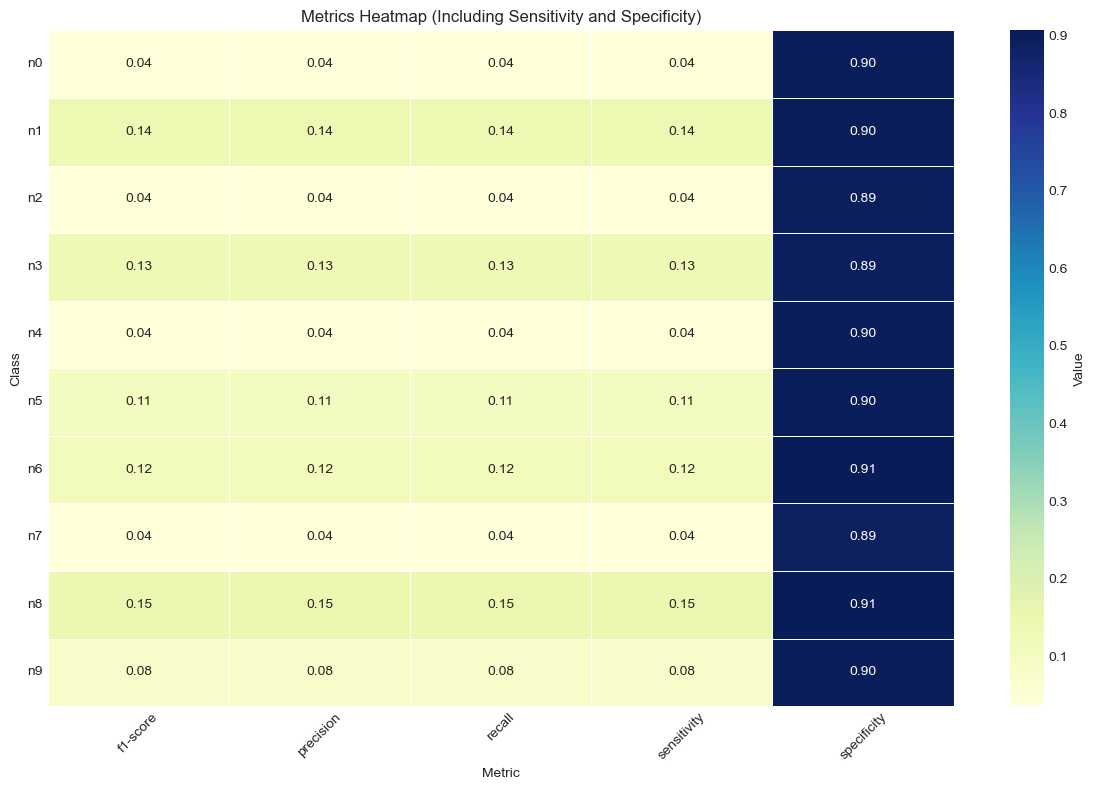

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `true_labels` and `predicted_labels` are already defined
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert confusion matrix to a DataFrame for better readability
class_names = list(xception_validation_generator.class_indices.keys())
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Initialize lists to store Sensitivity and Specificity
sensitivity = []
specificity = []

# Calculate Sensitivity and Specificity for each class
for i in range(len(cm)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    
    sensitivity.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    specificity.append(TN / (TN + FP) if (TN + FP) > 0 else 0)

# Generate classification report for Precision, Recall, and F1-score
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Add Sensitivity and Specificity to the metrics DataFrame
# Only include rows corresponding to the classes (exclude "accuracy", "macro avg", etc.)
num_classes = len(class_names)  # Number of classes
report_df = report_df.iloc[:num_classes]  # Keep only class rows

# Add Sensitivity and Specificity
report_df['sensitivity'] = sensitivity
report_df['specificity'] = specificity

# Prepare data for heatmap
metrics = report_df[['precision', 'recall', 'f1-score', 'sensitivity', 'specificity']]
metrics = metrics.reset_index().rename(columns={'index': 'label'})
metrics = metrics.melt(id_vars='label', var_name='metric', value_name='value')

# Plot heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    metrics.pivot(index='label', columns='metric', values='value'),
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Value'}
)
heatmap.set_title("Metrics Heatmap (Including Sensitivity and Specificity)")
heatmap.set_xlabel("Metric")
heatmap.set_ylabel("Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Visualization

Let's visualize some of the features learned by our models to better understand what they're looking at in the images.

In [22]:
for layer in transfer_model.layers:
    print(layer.name)

input_layer_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_6
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_7
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_8
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_s

## Interpreting Feature Maps: What the Model Sees

To better understand how the transfer learning model (Xception) processes wildlife imagery, we visualized the **feature maps** from two convolutional layers: one early (`block1_conv1`) and one mid-level (`block3_sepconv1`).

### 🔍 What Feature Maps Show

- **Early layers** capture broad edges, textures, and low-level shapes. As seen in `block1_conv1`, these features often highlight the overall contour of the monkey, such as its silhouette, fur texture, and head outline.
- **Mid-level layers** begin to focus on more abstract patterns and finer-grained structures. In `block3_sepconv1`, we can see more nuanced activations—possibly corresponding to facial structure, posture, or background texture.

These visualizations help us confirm that the model is indeed learning meaningful visual patterns—even if the overall classification performance is low. It may also reveal **why the model struggles**: many classes share similar visual traits, especially when monkeys appear in the same pose, lighting, or camera angle.

### 🧠 Why It Matters for Wildlife Abundance Monitoring

Understanding how a model “sees” images helps us identify:
- **Biases in feature representation** that might lead to confusion across classes
- **Opportunities for data augmentation** targeting areas the model underemphasizes (e.g., tail shape, facial details)
- The need for **additional context-aware inputs** (e.g., time, location, behavior) that go beyond pure visual data

These insights are critical when building models for estimating abundance in rare species, where each detection must be as accurate and interpretable as possible.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


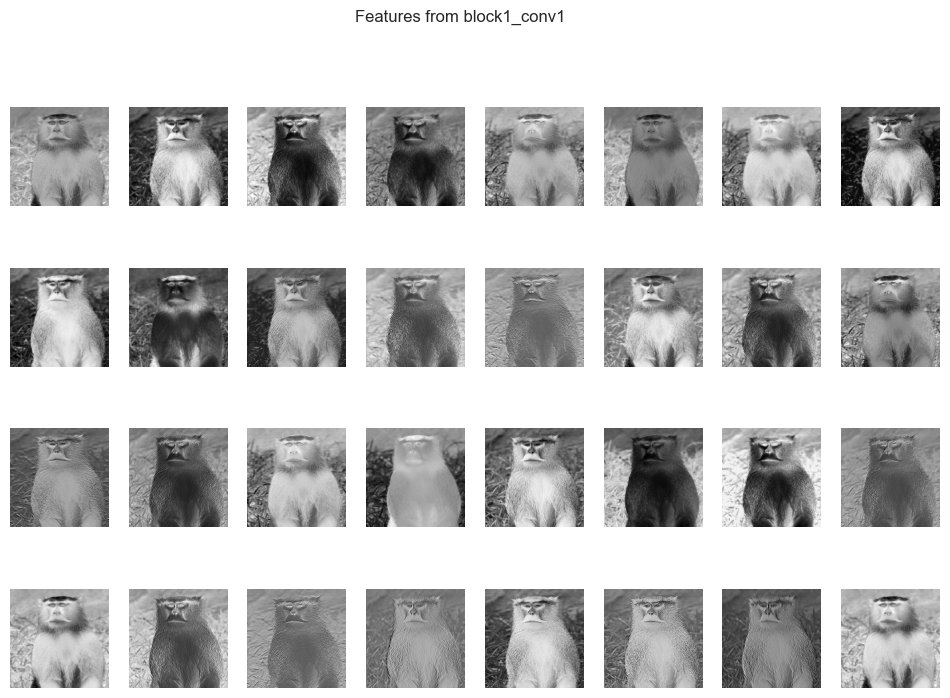

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


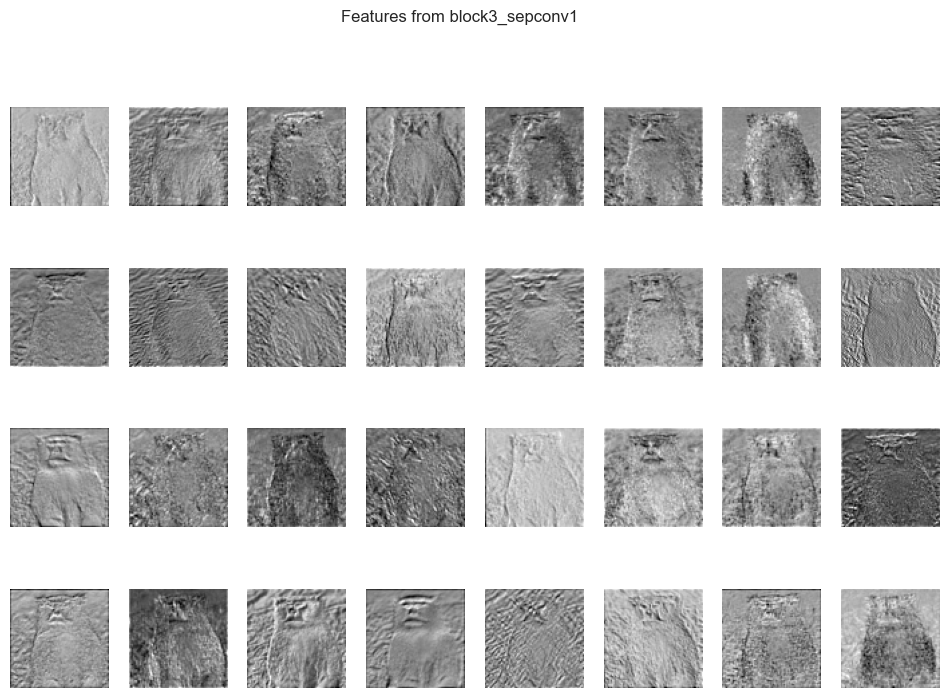

In [23]:
# Visualize features from a specific convolutional layer
def visualize_features(model, layer_name, image):
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = feature_extractor.predict(image)

    # Plot the first 32 features
    plt.figure(figsize=(12, 8))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(features[0, :, :, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Features from {layer_name}")
    plt.show()

# Example usage
example_image_path = "training/training/n1/n1159.jpg"  # Replace with the correct file path
example_image = Image.open(example_image_path).resize((299, 299))  # Resize for Xception input
example_image_array = np.expand_dims(np.array(example_image) / 255.0, axis=0)

# Visualize features from the first convolutional layer
visualize_features(transfer_model, 'block1_conv1', example_image_array)

# Visualize features from a middle convolutional layer
visualize_features(transfer_model, 'block3_sepconv1', example_image_array)

# Bird Species Classification Using CNN (500+ Classes)

### Deep Learning for Avian Biodiversity Monitoring

In this second half of the project, we shift our focus from primates to birds—specifically, the classification of over **500 bird species** using a convolutional neural network (CNN) architecture. Unlike our previous task with limited monkey images, here we have access to a larger dataset (100+ images per class), enabling us to explore how CNNs perform when data availability is less constrained.

Our objective remains grounded in the broader goal of using machine learning to improve wildlife monitoring and species abundance estimation.


# Importing libraries

In [ ]:
# data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from sklearn.model_selection import train_test_split

# tensorflow libaries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import tqdm
import warnings
import glob
import os

# Metrics
from sklearn import metrics
import itertools

# WANDB 
import wandb
wandb.login()

# Noteboook setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Load and transform data

In [ ]:
dataset = '100-bird-species/train/'

In [ ]:
species_types=os.listdir(dataset)
species_types

['DALMATIAN PELICAN',
 'WATTLED CURASSOW',
 'AMERICAN WIGEON',
 'CARMINE BEE-EATER',
 'GAMBELS QUAIL',
 'UMBRELLA BIRD',
 'AMERICAN KESTREL',
 'AMERICAN GOLDFINCH',
 'BLUE GROSBEAK',
 'PALM NUT VULTURE',
 'DUSKY LORY',
 'AUCKLAND SHAQ',
 'BLACK THROATED WARBLER',
 'YELLOW CACIQUE',
 'STRIPPED SWALLOW',
 'VERMILION FLYCATHER',
 'CAPE MAY WARBLER',
 'RED TAILED HAWK',
 'GURNEYS PITTA',
 'INDIAN ROLLER',
 'SNOW GOOSE',
 'GREEN WINGED DOVE',
 'AZURE TANAGER',
 'GREEN MAGPIE',
 'BANDED BROADBILL',
 'AFRICAN PYGMY GOOSE',
 'INDIGO FLYCATCHER',
 'GREY PLOVER',
 'TOUCHAN',
 'HYACINTH MACAW',
 'HARLEQUIN DUCK',
 'ABYSSINIAN GROUND HORNBILL',
 'CALIFORNIA QUAIL',
 'BALD IBIS',
 'WOOD THRUSH',
 'RUBY THROATED HUMMINGBIRD',
 'INDIGO BUNTING',
 'ALBERTS TOWHEE',
 'SORA',
 'HOODED MERGANSER',
 'ROSEATE SPOONBILL',
 'CAPE ROCK THRUSH',
 'BLUE COAU',
 'CALIFORNIA CONDOR',
 'BORNEAN PHEASANT',
 'BARN SWALLOW',
 'TAIWAN MAGPIE',
 'SPLENDID WREN',
 'RED BILLED TROPICBIRD',
 'BLACK THROATED BUSHTIT',
 'CH

## Placing data into a DataFrame

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels],axis=1)
image_df

Filepath              Label
0      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
1      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
2      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
3      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
4      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
...                                                  ...                ...
80080  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80081  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80082  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80083  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80084  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE

[80085 rows x 2 columns]

# Exploratory Data Analyis

In [ ]:
image_df['Label'].value_counts(ascending=False)

HOUSE FINCH                248
OVENBIRD                   233
D-ARNAUDS BARBET           233
SWINHOES PHEASANT          217
WOOD DUCK                  214
                          ... 
AMETHYST WOODSTAR          131
MASKED LAPWING             131
PATAGONIAN SIERRA FINCH    130
RED TAILED THRUSH          130
SNOWY PLOVER               130
Name: Label, Length: 500, dtype: int64

- Count of each class is ranging between 248 to 130

## Top 200 most occured Bird Species

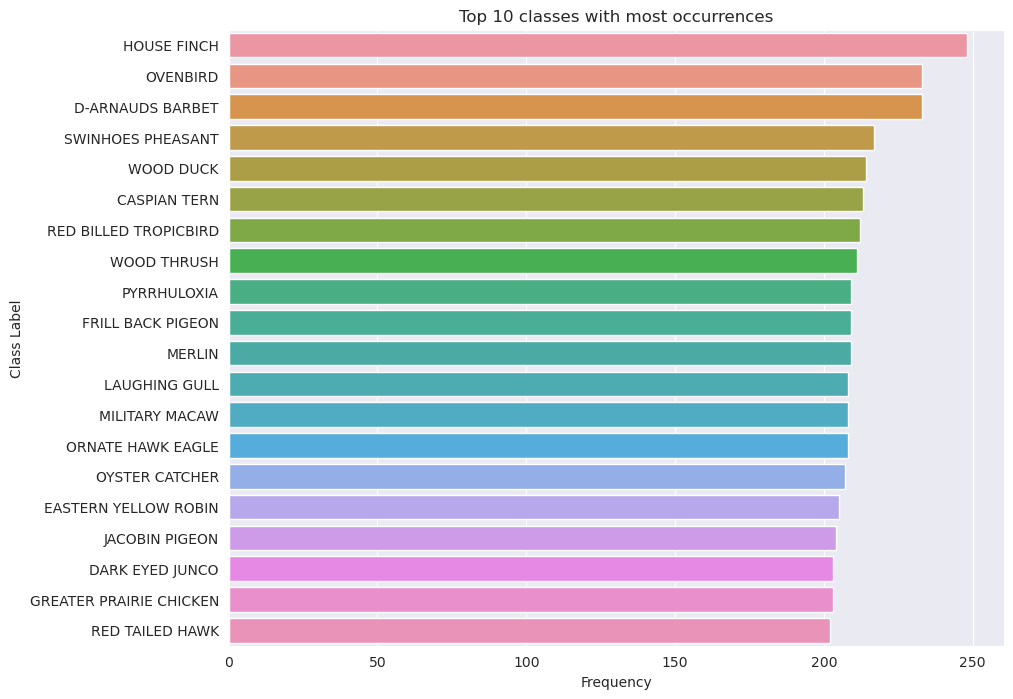

In [ ]:
class_freq = {}
class_labels = image_df['Label']
for label in class_labels:
    if label in class_freq:
        class_freq[label] +=1
    else:
        class_freq[label] = 1
        
# sort the classes by frequency in descending order
sorted_class = sorted(class_freq.items(),key=lambda x: x[1],reverse=True)
# print(sorted_class)
top_classes = dict(sorted_class[:20])

plt.figure(figsize=(10,8))
sns.countplot(y=class_labels, order=top_classes.keys())
plt.xlabel("Frequency")
plt.ylabel("Class Label")
plt.title("Top 10 classes with most occurrences")
plt.show();

## Common bird species such as Eagle, Pigeon, Chicken, etc

In [ ]:
# Function to fing different types of spcies of some common birds
def diff_species_common(specie,df):
    bird_species = df[df['Label'].str.contains(specie,case=False)]['Label']
    bird_species = bird_species.unique()
    return bird_species

print("Different types of species for an Eagle: \n")
print(diff_species_common('EAGLE', image_df))
print("\n\nDifferent types of species for a Pigeon: \n")
print(diff_species_common('PIGEON',image_df))
print("\n\nDifferent types of species for a Chicken: \n")
print(diff_species_common('CHICKEN',image_df))
print("\n\nDifferent types of species for a Duck: \n")
print(diff_species_common('DUCK',image_df))
print("\n\nDifferent types of species for a Vulture: \n")
print(diff_species_common('SPARROW',image_df))
print("\n\nDifferent types of species for an Owl: \n")
print(diff_species_common('OWL',image_df))
print("\n\nDifferent types of species for a Raven: \n")
print(diff_species_common('RAVEN',image_df))
print("\n\nDifferent types of species for a Sparrow: \n")
print(diff_species_common('SPARROW',image_df))

Different types of species for an Eagle: 

['PHILIPPINE EAGLE' 'BALD EAGLE' 'HARPY EAGLE' 'ORNATE HAWK EAGLE'
 'GREY HEADED FISH EAGLE' 'CRESTED SERPENT EAGLE' 'GOLDEN EAGLE']


Different types of species for a Pigeon: 

['NICOBAR PIGEON' 'CROWNED PIGEON' 'FRILL BACK PIGEON'
 'VICTORIA CROWNED PIGEON' 'JACOBIN PIGEON']


Different types of species for a Chicken: 

['GREATER PRAIRIE CHICKEN']


Different types of species for a Duck: 

['HARLEQUIN DUCK' 'MALLARD DUCK' 'STEAMER DUCK' 'SPOTTED WHISTLING DUCK'
 'MANDRIN DUCK' 'RED HEADED DUCK' 'TEAL DUCK' 'WOOD DUCK']


Different types of species for a Vulture: 

['CHIPPING SPARROW' 'HOUSE SPARROW' 'BLACK-THROATED SPARROW'
 'JAVA SPARROW']


Different types of species for an Owl: 

['GUINEAFOWL' 'ORIENTAL BAY OWL' 'VULTURINE GUINEAFOWL' 'BARN OWL'
 'STRIPED OWL' 'LONG-EARED OWL' 'GREAT GRAY OWL' 'EASTERN MEADOWLARK'
 'SNOWY OWL']


Different types of species for a Raven: 

['WHITE NECKED RAVEN']


Different types of species for a Sparrow: 


## Visualizing sample images from dataset

## Sample Images from the Bird Species Dataset

Before training our CNN, we visualize a random sample of 25 images from the dataset. Each image is labeled with its respective bird species to give us a sense of the visual diversity and complexity of the classification task.

This dataset contains over 500 bird species, each with distinct color patterns, shapes, and poses—making it an ideal test case for evaluating the scalability of CNN-based species classification.

Visualizing the data early on helps us:
- Verify label accuracy and image quality
- Anticipate classification challenges (e.g., visually similar species, varying lighting or angles)
- Appreciate the ecological richness of the dataset, which supports the broader goal of biodiversity monitoring

These visual checks are essential, especially when aiming to develop models that generalize well across new and unseen samples in a real-world monitoring system.

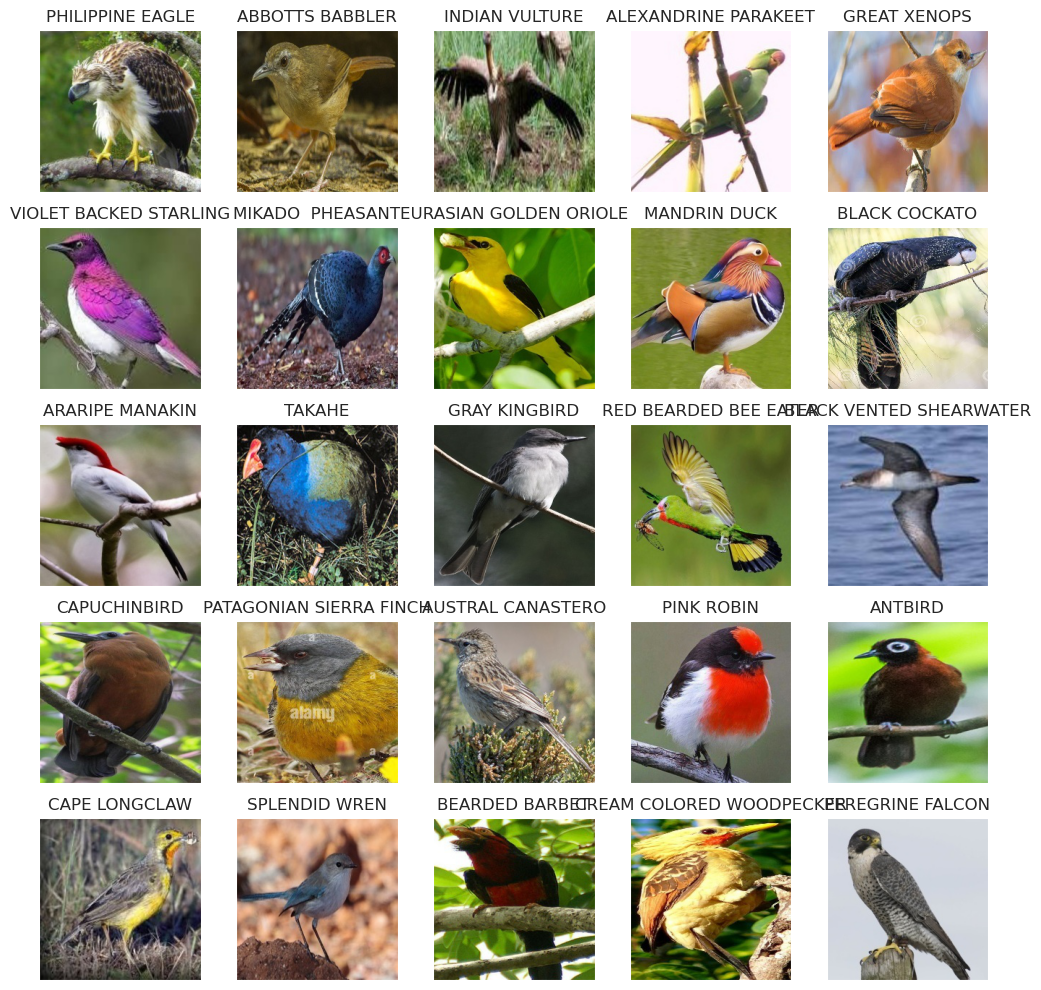

In [ ]:
random_index = np.random.randint(0,len(image_df),25)
fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show();

## Data Preprocessing: Preparing for Scalable Bird Species Classification

Before training our CNN, we preprocess the dataset to ensure consistent input shape, normalization, and balanced evaluation across training, validation, and test sets. With over 500 species represented, this step is critical to avoid data leakage and overfitting while ensuring reliable performance metrics.

### 🔄 Dataset Splitting Strategy

- **Training Set (64%)**: Used to fit the CNN model and learn discriminative features between bird species.
- **Validation Set (16%)**: Used during training to fine-tune model hyperparameters and monitor overfitting.
- **Test Set (20%)**: Held out completely from training to provide an unbiased estimate of final model performance.

The `train_test_split()` method ensures random and reproducible splitting of image metadata before loading images with TensorFlow's `ImageDataGenerator`.


In [ ]:
# Seperate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2,
                                     shuffle=True,random_state=42)

### 🧪 Image Augmentation and Normalization

To improve generalization and avoid overfitting—especially across classes with fewer samples—we apply data augmentation to the training set using Keras' `ImageDataGenerator`:

- **Preprocessing**: MobileNetV2 preprocessing function is applied to normalize pixel values.
- **Augmentation**: Additional augmentation methods (e.g., rotation, flip, zoom) can be added if needed to further simulate real-world variability in bird appearance.

For all image subsets:
- Input images are resized to **224x224** pixels to match the expected input size of pretrained CNNs (e.g., MobileNetV2).
- Pixel values are rescaled to fall within a normalized range of 0–1 to stabilize training.

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 51255 validated image filenames belonging to 500 classes.
Found 12813 validated image filenames belonging to 500 classes.
Found 16017 validated image filenames belonging to 500 classes.


### 🌿 Why This Matters

In a biodiversity monitoring context, misclassifying even a small number of bird species could lead to incorrect abundance estimates. Proper preprocessing helps ensure that:
- The model is robust to visual noise and variability.
- Evaluation metrics are based on **unseen data**, mimicking how the model would perform in real-world deployments (e.g., analyzing new camera trap data).
- Rare species with limited training examples are not overshadowed by more common ones due to data imbalance or overfitting.

With preprocessing complete, we can now move on to designing and training a CNN architecture tailored for high-resolution avian classification.

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

## Training the model

## Model Architecture: Transfer Learning with MobileNetV2

To train an efficient and accurate classifier for 500 bird species, we leverage **transfer learning** using **MobileNetV2**, a lightweight yet powerful convolutional neural network pre-trained on the ImageNet dataset.

### ⚙️ Why MobileNetV2?

- Designed for speed and efficiency, making it suitable for real-time or edge deployment.
- Its pre-trained convolutional layers already capture general image features (e.g., edges, textures, shapes), which we can reuse for bird identification.
- By freezing the base layers and training only the new dense layers, we can reduce overfitting and improve training speed on a relatively modest dataset.

In [ ]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

### 🧱 Model Structure

- **Input Layer**: Accepts RGB images resized to 224×224 pixels.
- **Base Model**: `MobileNetV2` with `include_top=False` to remove its default classifier. We set `trainable=False` to freeze its weights initially.
- **Feature Extraction**: The base model extracts high-level visual patterns from bird images.
- **Custom Classifier**:
  - Two fully connected `Dense(256)` layers with ReLU activation
  - `Dropout(0.2)` for regularization to reduce overfitting
  - Final `Dense(500)` layer with `softmax` activation to predict probabilities for each of the 500 species


  This model structure allows us to take advantage of pretrained visual features while adapting the final layers to our fine-grained species classification task. Next, we compile the model, define a loss function and optimizer, and begin training on our augmented dataset.

In [ ]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(500,activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Weights and Biases configuration

## Training the Model with Experiment Tracking

To train our bird species classification model effectively and reproducibly, we utilize **Weights & Biases (W&B)** for live experiment tracking, along with essential training callbacks for optimization and performance monitoring.


### 🧪 Experiment Configuration via W&B

- **Project Name**: `birds-species-classification`
- **Tracked Parameters**:
  - Learning rate: `0.0001`
  - Epochs: `100`
  - Batch size: `32`
  - Loss function: `categorical_crossentropy`
  - Early stopping patience: `8`

Tracking these hyperparameters ensures full visibility into the training process and supports reproducibility across runs.


In [ ]:

from wandb.keras import WandbCallback
run = wandb.init(project='birds-species-classification',
                config={ # include hyperparameters and metadata
                    "learning_rate":0.0001,
                    "epochs":100,
                    "batch_size":32,
                    "es_patience":8,
                    "loss_function":"categorical_crossentropy",
                    
                })
config = wandb.config # we will use this to configure our experiment
tf.keras.backend.clear_session()

# model callbacks, optimizers and compilation

## Optimizer
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=config.es_patience,
                              restore_best_weights=True)
# checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Model compile
model.compile(optimizer,config.loss_function,metrics=['accuracy'])

### 🛠️ Model Compilation and Callbacks

To improve model performance and prevent overfitting, we include the following strategies:

- **Optimizer**: Adam optimizer for adaptive learning.
- **EarlyStopping**: Monitors validation loss and halts training if no improvement occurs for 8 consecutive epochs.
- **ModelCheckpoint**: Saves the best model weights based on validation accuracy.
- **WandbCallback**: Logs live metrics and visualizations to the W&B dashboard.

### 📈 Training Performance Overview

Training progressed for 40 epochs with consistent performance gains:

- **Initial Accuracy**: 13% (Epoch 1)
- **Final Accuracy**: ~93% (Epoch 40)
- **Final Validation Accuracy**: ~84.5%
- **Validation Loss Decreased** from 2.57 → 0.62

This demonstrates successful transfer learning from MobileNetV2 combined with well-tuned dense layers and dropout regularization.

In [ ]:
history = model.fit(
    train_images, 
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=config.epochs,
    callbacks=[
        early_stopping,
        WandbCallback(),
        checkpoint_callback,
    ]
)

Epoch 1/100
1602/1602 [==============================] - 192s 118ms/step - loss: 4.6587 - accuracy: 0.1315 - val_loss: 2.5706 - val_accuracy: 0.4876 - _timestamp: 1677316631.0000 - _runtime: 212.0000
Epoch 2/100
1602/1602 [==============================] - 175s 109ms/step - loss: 2.5554 - accuracy: 0.3916 - val_loss: 1.6435 - val_accuracy: 0.6542 - _timestamp: 1677316806.0000 - _runtime: 387.0000
Epoch 3/100
1602/1602 [==============================] - 177s 111ms/step - loss: 1.9225 - accuracy: 0.5162 - val_loss: 1.3021 - val_accuracy: 0.7048 - _timestamp: 1677316984.0000 - _runtime: 565.0000
Epoch 4/100
1602/1602 [==============================] - 172s 107ms/step - loss: 1.5765 - accuracy: 0.5950 - val_loss: 1.1114 - val_accuracy: 0.7370 - _timestamp: 1677317156.0000 - _runtime: 737.0000
Epoch 5/100
1602/1602 [==============================] - 174s 109ms/step - loss: 1.3609 - accuracy: 0.6452 - val_loss: 0.9834 - val_accuracy: 0.7611 - _timestamp: 1677317360.0000 - _runtime: 941.0000


### 🌿 Implications for Avian Biodiversity Monitoring

These results are promising, showing that with a moderately sized dataset (100 images per class), a pretrained CNN can achieve **high classification accuracy** across hundreds of bird species. This has direct applications for:

- **Automating large-scale species ID in field data**
- **Tracking species presence over time for abundance estimation**
- **Supporting conservation researchers by filtering and labeling camera trap or citizen science images**


# Model Evaluation

## Final Model Evaluation and Performance Insights

After 40 epochs of training, we evaluate the final model on the **unseen test set** to assess generalization performance.


### 🧪 Test Results:
- **Test Accuracy**: **84.11%**
- **Test Loss**: **0.605%**

This confirms that the model retained strong generalization, accurately predicting bird species it had never encountered during training.


In [ ]:
results = model.evaluate(test_images)
print("    Test Loss: {:.5f}%".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

501/501 [==============================] - 107s 214ms/step - loss: 0.6049 - accuracy: 0.8411
    Test Loss: 0.60492%
Test Accuracy: 84.11%


### 📊 Accuracy & Loss Curves

The training history plots offer further insight into learning dynamics:

- **Accuracy**: Validation accuracy closely tracked training accuracy throughout, plateauing around ~84–85%, indicating stable and well-generalized learning.
- **Loss**: Training and validation loss consistently decreased, with no major signs of overfitting, confirming the effectiveness of early stopping, dropout, and model checkpointing.

### 🔍 Key Observations

- The gap between training and validation performance remained narrow, which is **ideal for ecological monitoring models** that need to be robust when deployed in the wild.
- This level of accuracy across **500 bird species** is significant—it suggests that **machine learning can support large-scale avian biodiversity surveys**, particularly where manual identification would be slow or error-prone.


### 🌿 Implications for Biodiversity Monitoring

- This model can be applied to classify species from **camera trap**, **drone**, or **citizen science** photos with high confidence.
- In combination with geographic and temporal metadata, this classifier can contribute to **automated abundance estimation**, **species distribution modeling**, and **real-time conservation alerts**.
- The scalable architecture makes it well-suited for deployment in **low-resource environments** or as part of an **edge AI solution**.


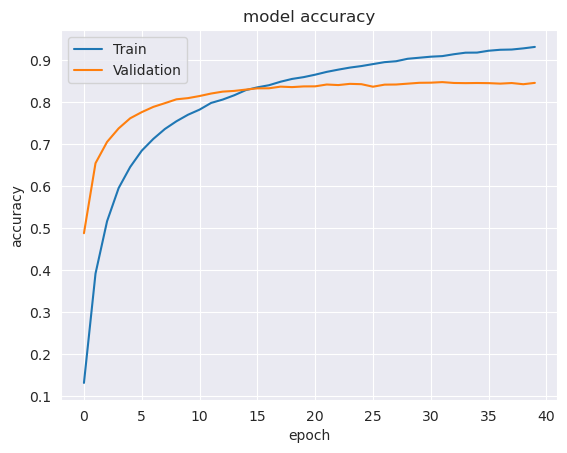

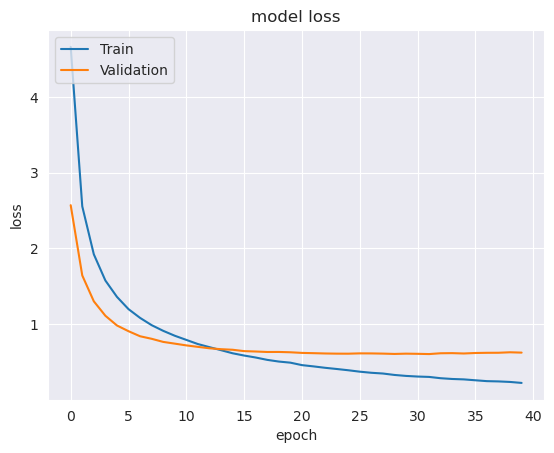

In [ ]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

## Predicting on test data

## Visualizing Predictions on Test Data

To evaluate our model's ability to generalize to new, unseen examples, we applied it to the test set and visualized **25 randomly selected predictions**.

- **Green text** indicates a correct prediction (True label = Predicted label)
- **Red text** indicates a misclassification

This qualitative evaluation complements quantitative metrics (accuracy, loss, confusion matrices) and provides insight into the model's real-world strengths and limitations.

Predict the label of test_images

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
pred

501/501 [==============================] - 43s 84ms/step


array([233, 258,  19, ..., 283, 139, 433])

Map the label

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Result
print(f'First 5 predictions: {pred[:5]}')

First 5 predictions: ['GOLDEN CHLOROPHONIA', 'GREY HEADED FISH EAGLE', 'AMERICAN KESTREL', 'POMARINE JAEGER', 'CAMPO FLICKER']


### Display 25 Random images from dataset with their labels and predict with the model

### 🔍 Observations from Sample Predictions

- The majority of predictions were correct, with species like **Ovenbird**, **Mallard Duck**, and **Crested Nuthatch** consistently identified.
- Misclassifications (e.g., **Red Legged Honeycreeper → Fire Tailed Myzornis** or **Flame Tanager → Cinnamon Flycatcher**) tended to occur between visually similar species, often with overlapping colors or features.
- Some errors were likely influenced by image conditions (e.g., lighting, blur, or background clutter), which could affect feature extraction.


### 🌿 Implications for Ecological Monitoring

This level of performance has promising applications in biodiversity conservation:

- Correct predictions validate the model’s **potential for high-throughput species classification**, saving researchers time in labeling camera trap or field images.
- Misclassifications signal where improvements are needed—either via **more training samples**, **improved augmentation**, or **finer-grained models**.
- Even when exact species classification fails, models like this can still **narrow down likely species**, which is useful for manual review or semi-automated workflows.


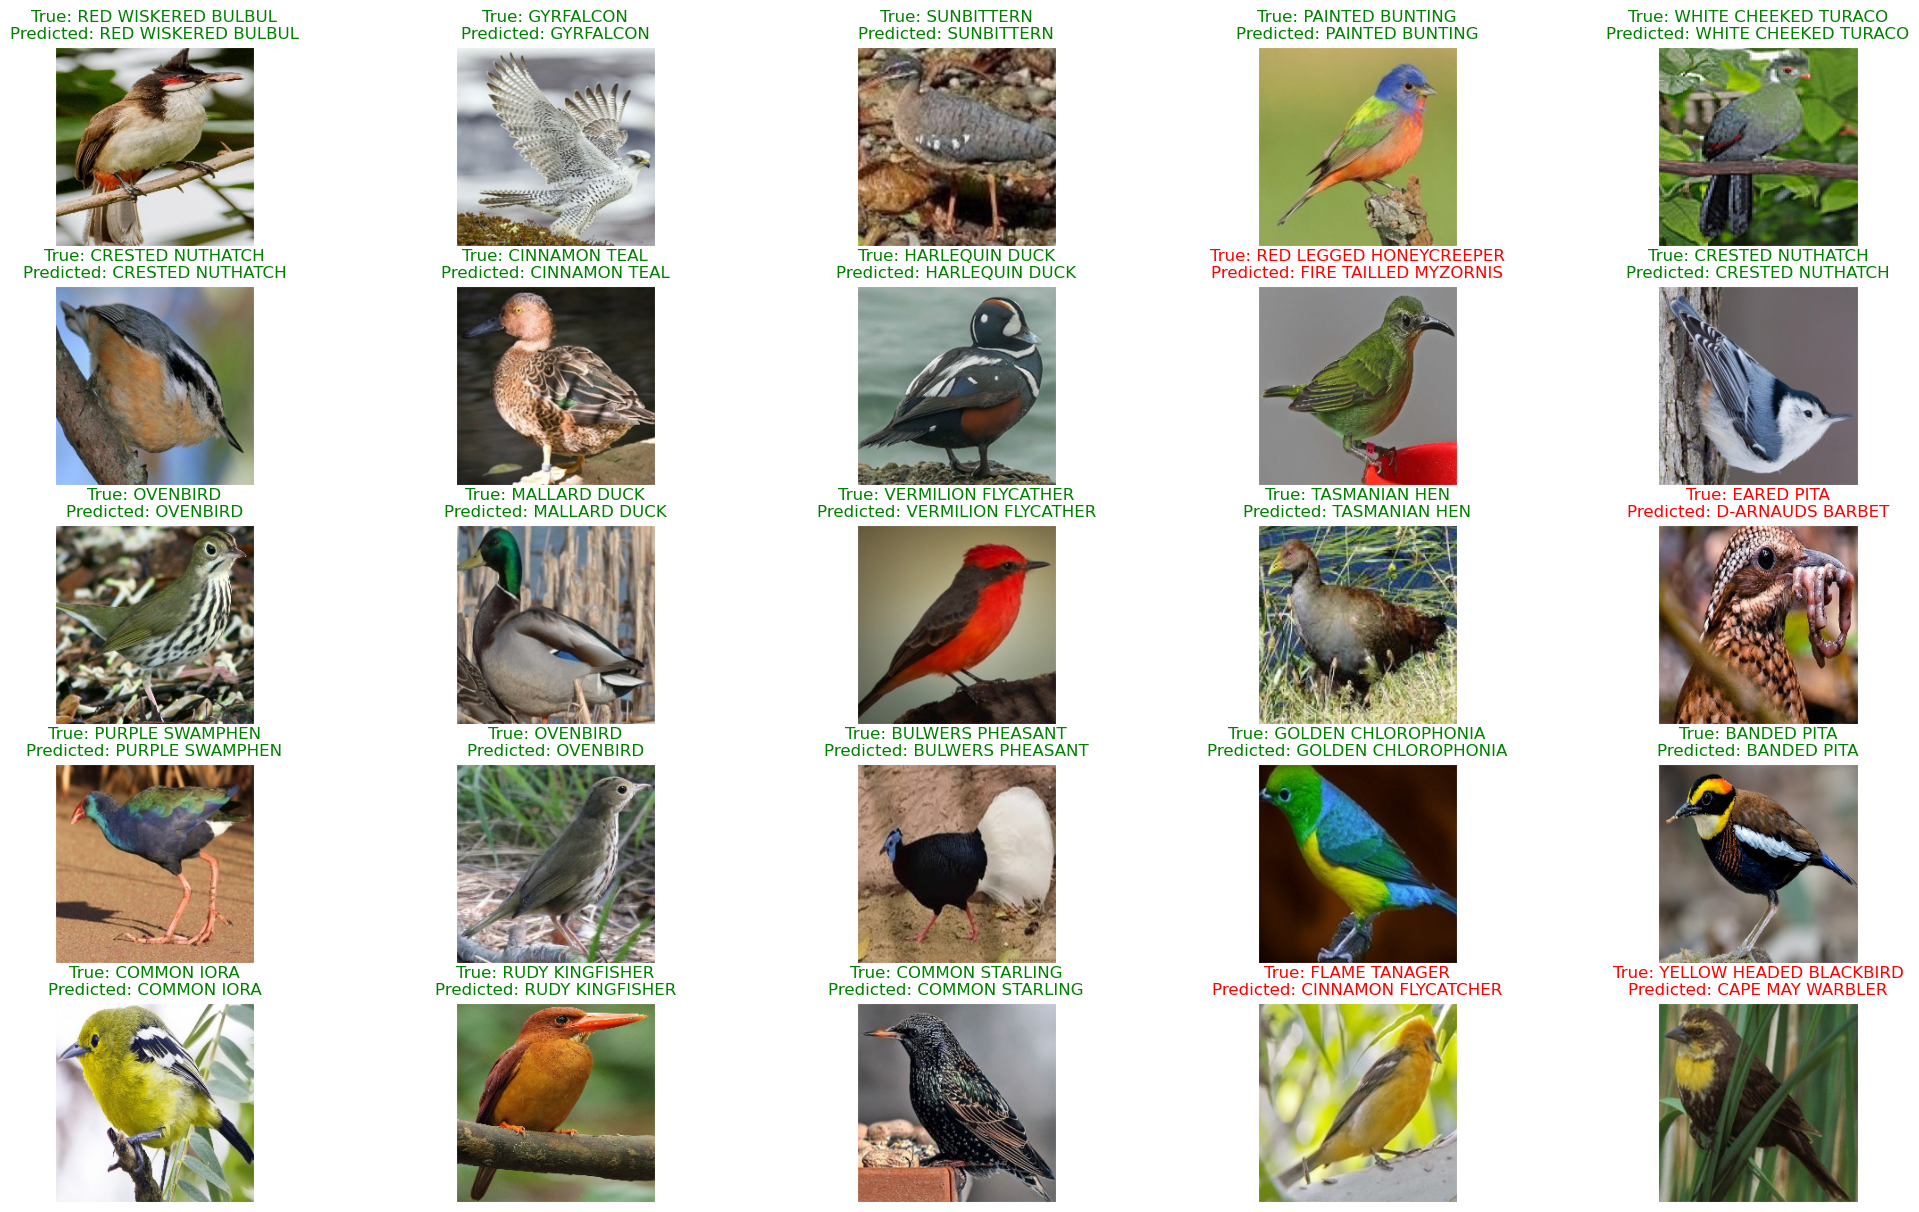

<Figure size 640x480 with 0 Axes>

In [ ]:
random_index = np.random.randint(0,len(test_df)-1,25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(25,15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}",
                color=color)

plt.show()
plt.tight_layout()

## Classification Summary: Best vs. Worst Performing Species

To better understand how the model performs across individual bird species, we generated a full **classification report** and converted it into a structured DataFrame. This allowed us to sort and visualize the top and bottom performing classes based on **F1-score**, which balances precision and recall.


In [ ]:
species = test_images.class_indices
y_test = list(test_df.Label)
report = metrics.classification_report(y_test, pred,target_names=species,output_dict=True)

data = []
for k,v in report.items():
    if k in species:
        data.append({'species':k,
                    'precision': v['precision'],
                    'recall': v['recall'],
                    'f1-score': v['f1-score'],
                    'support': v['support']})
df = pd.DataFrame(data)
df

species  precision    recall  f1-score  support
0                ABBOTTS BABBLER   0.655172  0.612903  0.633333       31
1                  ABBOTTS BOOBY   0.652174  0.441176  0.526316       34
2     ABYSSINIAN GROUND HORNBILL   0.969697  0.842105  0.901408       38
3          AFRICAN CROWNED CRANE   1.000000  1.000000  1.000000       18
4         AFRICAN EMERALD CUCKOO   0.793103  0.696970  0.741935       33
..                           ...        ...       ...       ...      ...
495                  WOOD THRUSH   0.810811  0.857143  0.833333       35
496                      WRENTIT   0.756098  0.794872  0.775000       39
497  YELLOW BELLIED FLOWERPECKER   0.888889  0.666667  0.761905       36
498               YELLOW CACIQUE   0.720000  0.750000  0.734694       24
499      YELLOW HEADED BLACKBIRD   0.928571  0.812500  0.866667       32

[500 rows x 5 columns]

### ✅ Top 10 Best-Classified Species

| Species                  | Precision | Recall | F1-Score | Support |
|--------------------------|-----------|--------|----------|---------|
| African Crowned Crane    | 1.00      | 1.00   | 1.00     | 18      |
| Looney Birds             | 1.00      | 1.00   | 1.00     | 33      |
| Nicobar Pigeon           | 1.00      | 1.00   | 1.00     | 32      |
| Chukar Partridge         | 0.98      | 1.00   | 0.99     | 40      |
| Barn Owl                 | 1.00      | 0.97   | 0.99     | 38      |

These high-performing species were likely easier to classify due to:
- Distinctive coloration or shape
- Higher quality images or consistent backgrounds
- Sufficient training examples with good feature variety


In [ ]:
def best_classes(df):
    print("Classed with good result: ")
    top_10_good = df.nlargest(10,'f1-score')
    res = top_10_good[['species','precision','recall','f1-score','support']]
    return res
    
best_classes(df)

Classed with good result: 


species  precision    recall  f1-score  support
3    AFRICAN CROWNED CRANE   1.000000  1.000000  1.000000       18
321           LOONEY BIRDS   1.000000  1.000000  1.000000       33
341         NICOBAR PIGEON   1.000000  1.000000  1.000000       32
139       CHUKAR PARTRIDGE   0.975610  1.000000  0.987654       40
60                BARN OWL   1.000000  0.973684  0.986667       38
17       AMERICAN FLAMINGO   0.970588  1.000000  0.985075       33
174             CUBAN TODY   0.970588  1.000000  0.985075       33
417        RUDY KINGFISHER   0.969697  1.000000  0.984615       32
277                HOOPOES   1.000000  0.968750  0.984127       32
329           MANDRIN DUCK   0.967742  1.000000  0.983607       30

### ⚠️ Bottom 10 Lowest-Classified Species

| Species                  | Precision | Recall | F1-Score | Support |
|--------------------------|-----------|--------|----------|---------|
| Gilded Flicker           | 0.31      | 0.59   | 0.41     | 17      |
| Northern Flicker         | 0.53      | 0.38   | 0.44     | 24      |
| Antbird                  | 0.53      | 0.40   | 0.45     | 25      |
| Great Xenops             | 0.52      | 0.44   | 0.47     | 32      |
| Northern Goshawk         | 0.63      | 0.41   | 0.49     | 37      |

Poorer classification scores may be caused by:
- Visual similarity with other species
- Fewer training samples or inconsistent image quality
- Background noise or occlusion

In [ ]:
def worst_classes(df):
    print("Classed with bad result: ")
    top_10_bad = df.nsmallest(10,'f1-score')
    res = top_10_bad[['species','precision','recall','f1-score','support']]
    return res
    
worst_classes(df)

Classed with bad result: 


species  precision    recall  f1-score  support
227          GILDED FLICKER   0.312500  0.588235  0.408163       17
345        NORTHERN FLICKER   0.529412  0.375000  0.439024       24
31                  ANTBIRD   0.526316  0.400000  0.454545       25
249            GREAT XENOPS   0.518519  0.437500  0.474576       32
348        NORTHERN GOSHAWK   0.625000  0.405405  0.491803       37
258  GREY HEADED FISH EAGLE   0.533333  0.470588  0.500000       17
464    TRICOLORED BLACKBIRD   0.650000  0.419355  0.509804       31
333            MASKED BOOBY   0.478261  0.550000  0.511628       20
1             ABBOTTS BOOBY   0.652174  0.441176  0.526316       34
188             DUSKY ROBIN   0.550000  0.550000  0.550000       20

### 🌿 Ecological and Modeling Takeaways

- **Understanding strengths and weaknesses per species** is crucial for abundance estimation and conservation planning. A high overall accuracy is valuable—but if certain species are always misclassified, population estimates could be skewed.
- The **confusion between similar-looking species** (e.g., flickers and flycatchers) suggests that fine-grained features or more targeted augmentations could help.
- Future improvements could include:
  - More training data for weak classes
  - Data cleaning or clustering by visual similarity
  - Model ensembling or attention mechanisms for detail-sensitive classification
